In [1]:
import matplotlib.pyplot as plt

from myAE import Manager

import torch
from torch import nn
import torch.nn.functional as F

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager = Manager()
manager.prepare_data()
manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=30)
manager.add_model('vanilla 30')

Now, it is working on cuda:1.


100%|██████████| 30/30 [02:48<00:00,  5.60s/it]


In [12]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = -((pred - x).square() + 1e-6).log().mean()
    loss = ll + kl
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=10)
manager.add_model('pixel_entropy 10')

Now, it is working on cuda:0.


100%|██████████| 10/10 [01:12<00:00,  7.21s/it]


In [14]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = ((pred - x).square() + 1e-6).log().mean()
    loss = ll + kl
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=10)
manager.add_model('pixel_entropy - 10')

Now, it is working on cuda:0.


100%|██████████| 10/10 [01:12<00:00,  7.21s/it]


In [2]:
def compare_with_vanilla(manager, name, original_name='vavilla 30'):
    fig, (axs1, axs2, axs3) = plt.subplots(nrows=3, ncols=5, figsize=[20, 13])

    manager.swap_current_model(original_name)
    manager.model.to('cpu')
    manager.model.eval()

    for x, y in manager.train_dataloader:
        with torch.no_grad():
            h = manager.model.get_submodule("encoder")(x)
            mu = h[:, :2]
            x_hats = manager.model.get_submodule("decoder")(mu)
        for ax, img in zip(axs1, x[:5]):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        for ax, img in zip(axs2, x_hats):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')

        
        with torch.no_grad():
            manager.swap_current_model(name)

            manager.model.to('cpu')
            manager.model.eval()

            h = manager.model.get_submodule("encoder")(x)
            mu = h[:, :2]
            x_hats = manager.model.get_submodule("decoder")(mu)
        for ax, img in zip(axs3, x_hats):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        
        break
    plt.tight_layout()

Now, it is working on cuda:1.


100%|██████████| 30/30 [02:55<00:00,  5.85s/it]


KeyError: 'vanilla 10'

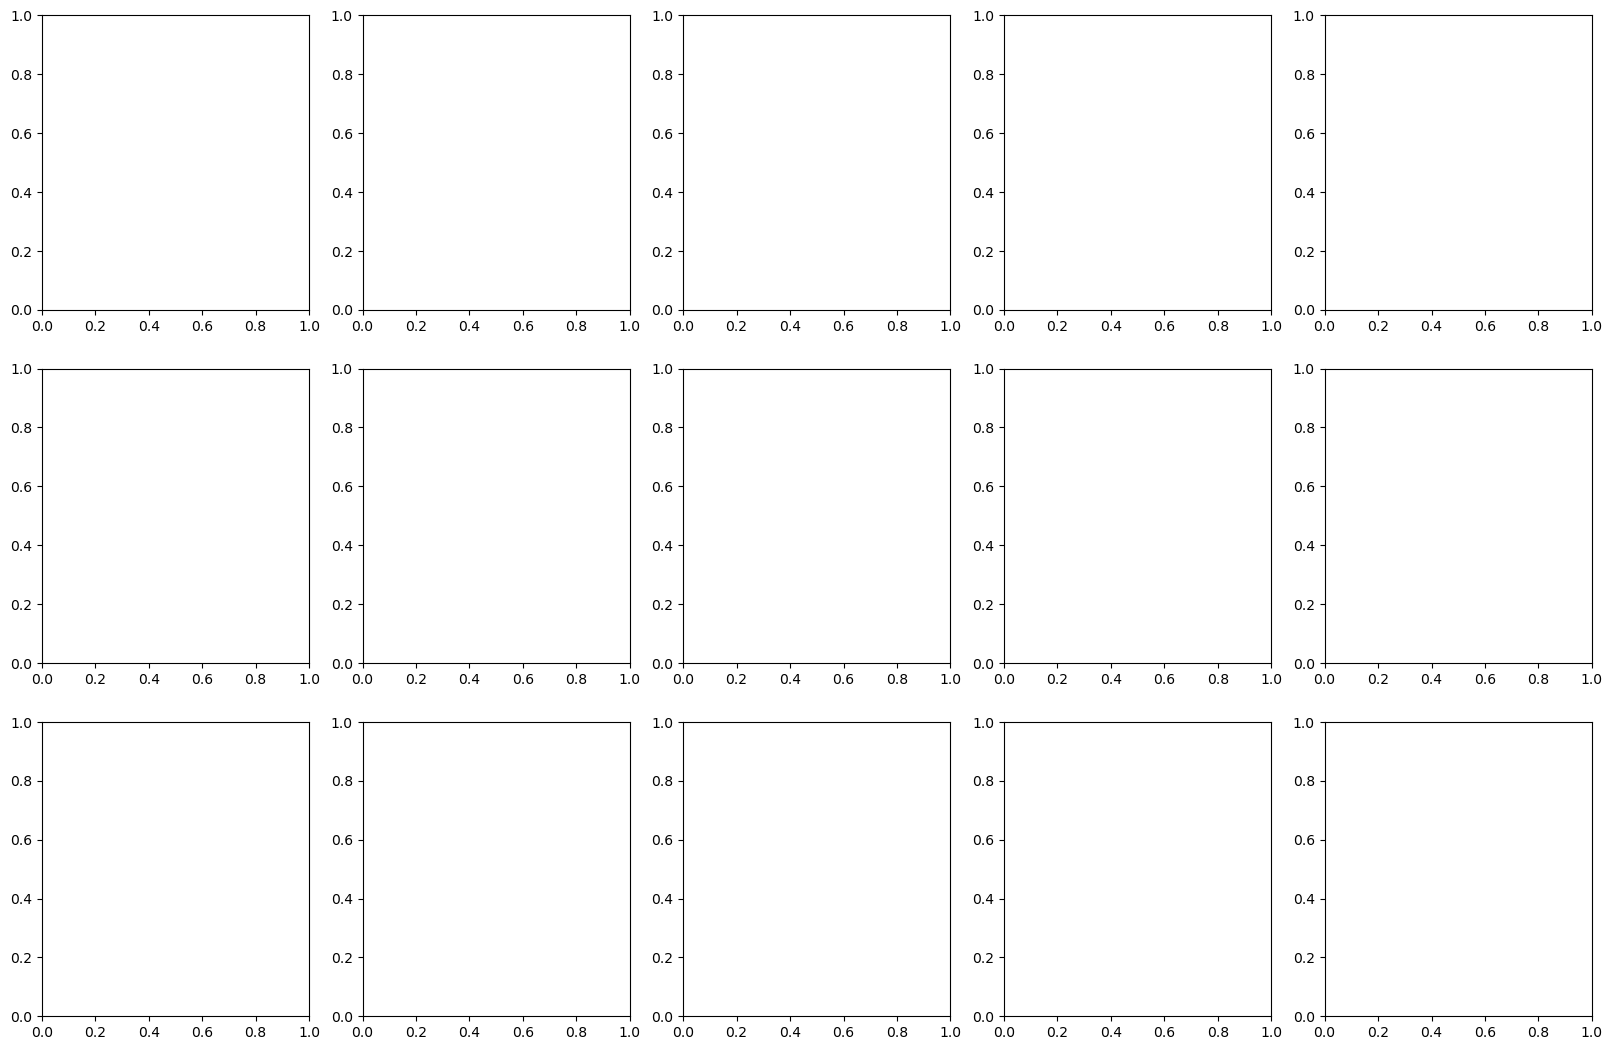

In [5]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    pe = (-(pred - 0.5).square() + 0.25).sum()/len(x)
    loss = ll + kl + pe
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=30)
name = 'square 30'
manager.add_model(name)
compare_with_vanilla(name)

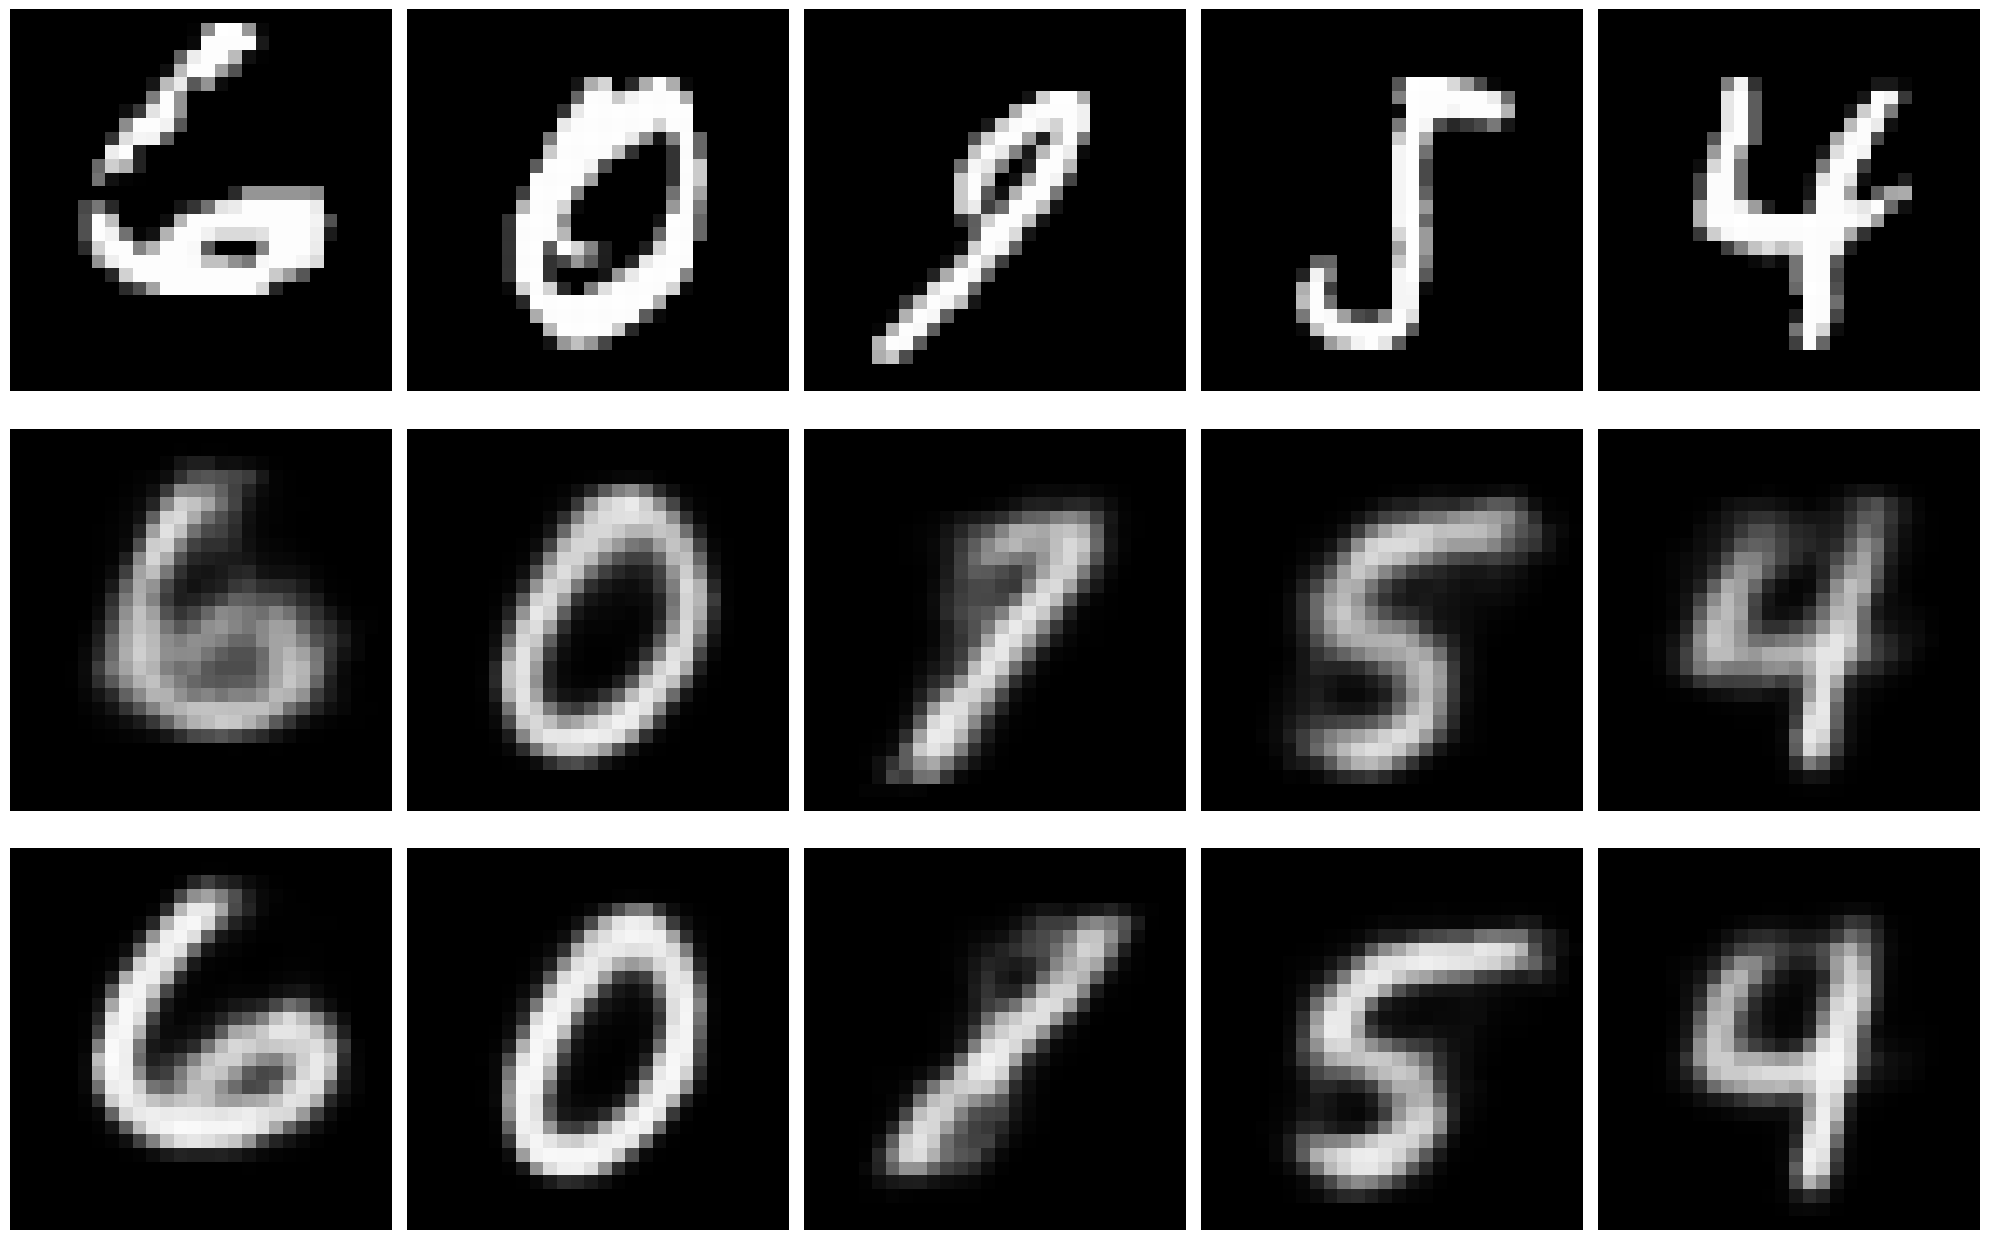

In [36]:
compare_with_vanilla(name)

#### 흐린 데이터는?

In [3]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager_2 = Manager()
manager_2.prepare_data()

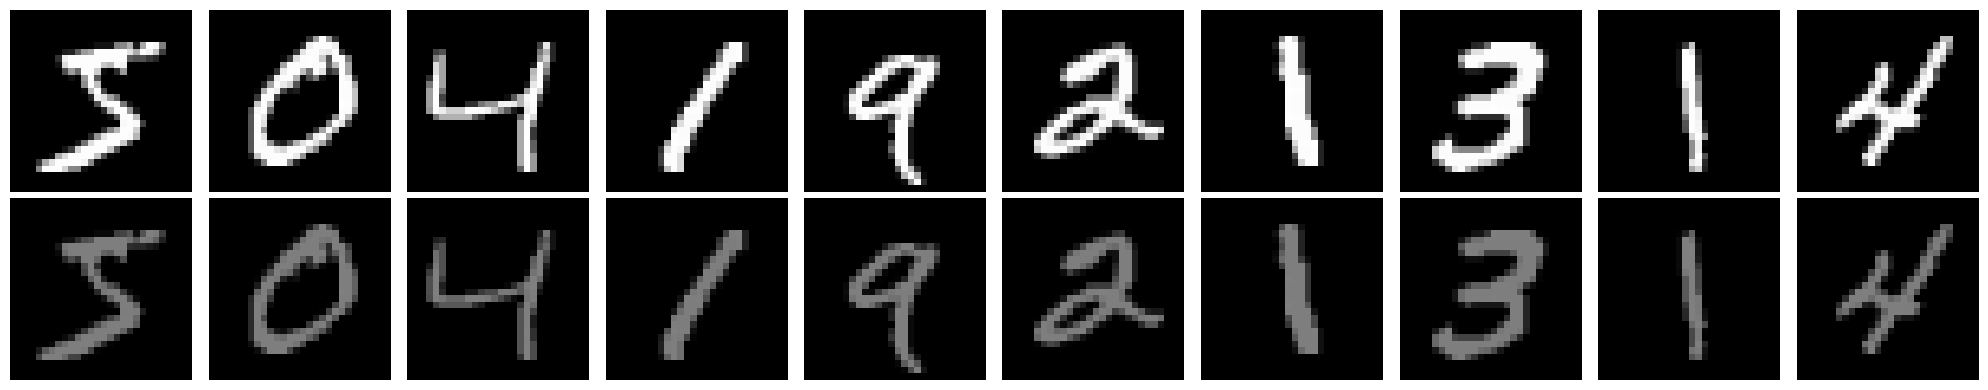

In [29]:
tmp_x = manager_2.training_data[:10]
tmp_x_b = manager_2.training_data[:10].clone() / 2

_, (axs_1, axs_2) = plt.subplots(2, 10, figsize=[20, 4])
for ax, img in zip(axs_1, tmp_x):
    ax.imshow(img.view(28, 28), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

for ax, img in zip(axs_2, tmp_x_b):
    ax.imshow(img.view(28, 28), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(
            root="data",
            train=True,
            download=True,
            transform=ToTensor(),
        )

class CustomImageDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.view([-1, 1, 28, 28])
        self.y = y 

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

manager_2.training_data_length = len(training_data.data)

manager_2.train_dataloader = DataLoader(
            CustomImageDataset(training_data.data / 255.0 / 2, training_data.targets), batch_size=128, shuffle=True
        )

In [76]:
training_data.targets.shape

torch.Size([60000])

In [67]:
print(training_data.data[0].max())
print(training_data.data[0].min())

tensor(0.5000)
tensor(0.)


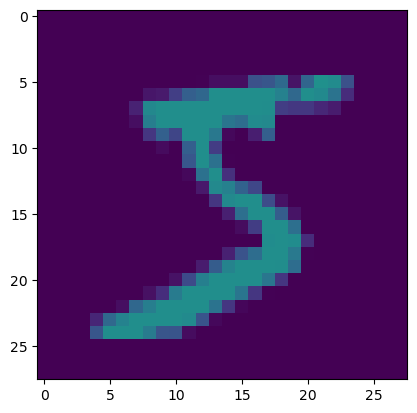

In [68]:
plt.imshow(training_data.data[0], vmax=1, vmin=0)

torch.Size([128, 28, 28])
tensor(0.4980)
tensor(0.)
tensor(0.5000)
tensor(0.)
tensor(0.5000)
tensor(0.)
tensor(0.5000)
tensor(0.)
tensor(0.4980)
tensor(0.)


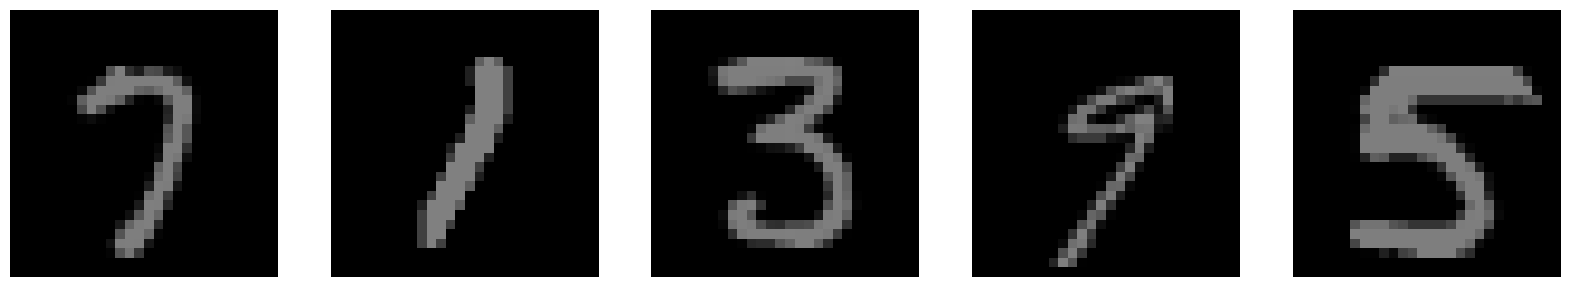

In [6]:
_, axs = plt.subplots(1, 5, figsize=[20, 5])

for x, y in manager_2.train_dataloader:
    print(x.shape)
    for ax, img in zip(axs, x[:5]):
        print(img.max())
        print(img.min())
        ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    break

In [8]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager_2.set_default_model(4, 2)

hist = manager_2.train(calc_loss, epochs=30)
manager_2.add_model('vanilla 30 v2')

Now, it is working on cuda:1.


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [01:51<00:00,  3.71s/it]


Now, it is working on cuda:1.


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [01:58<00:00,  3.94s/it]


AttributeError: 'str' object has no attribute 'swap_current_model'

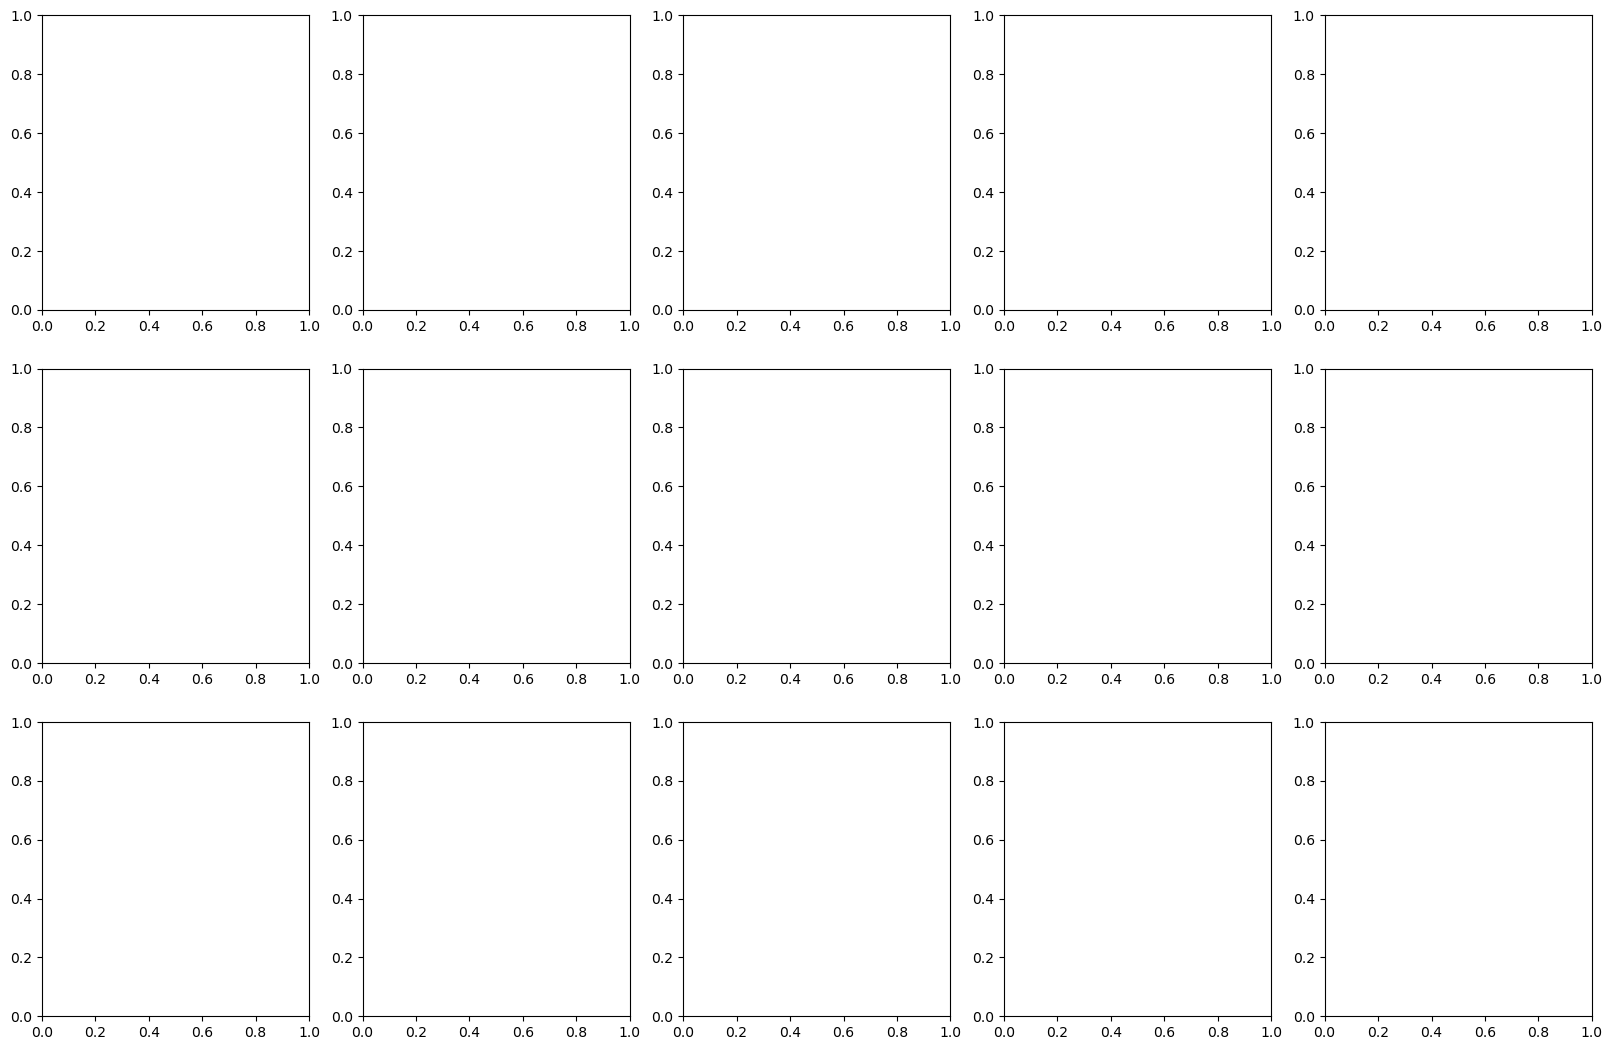

In [9]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    pe = (-(pred - 0.5).square() + 0.25).sum()/len(x)
    loss = ll + kl + pe
    return loss

manager_2.set_default_model(4, 2)

hist = manager_2.train(calc_loss, epochs=30)
name = 'square 30 v2'
manager_2.add_model(name)
compare_with_vanilla(name, 'vanilla 30 v2')

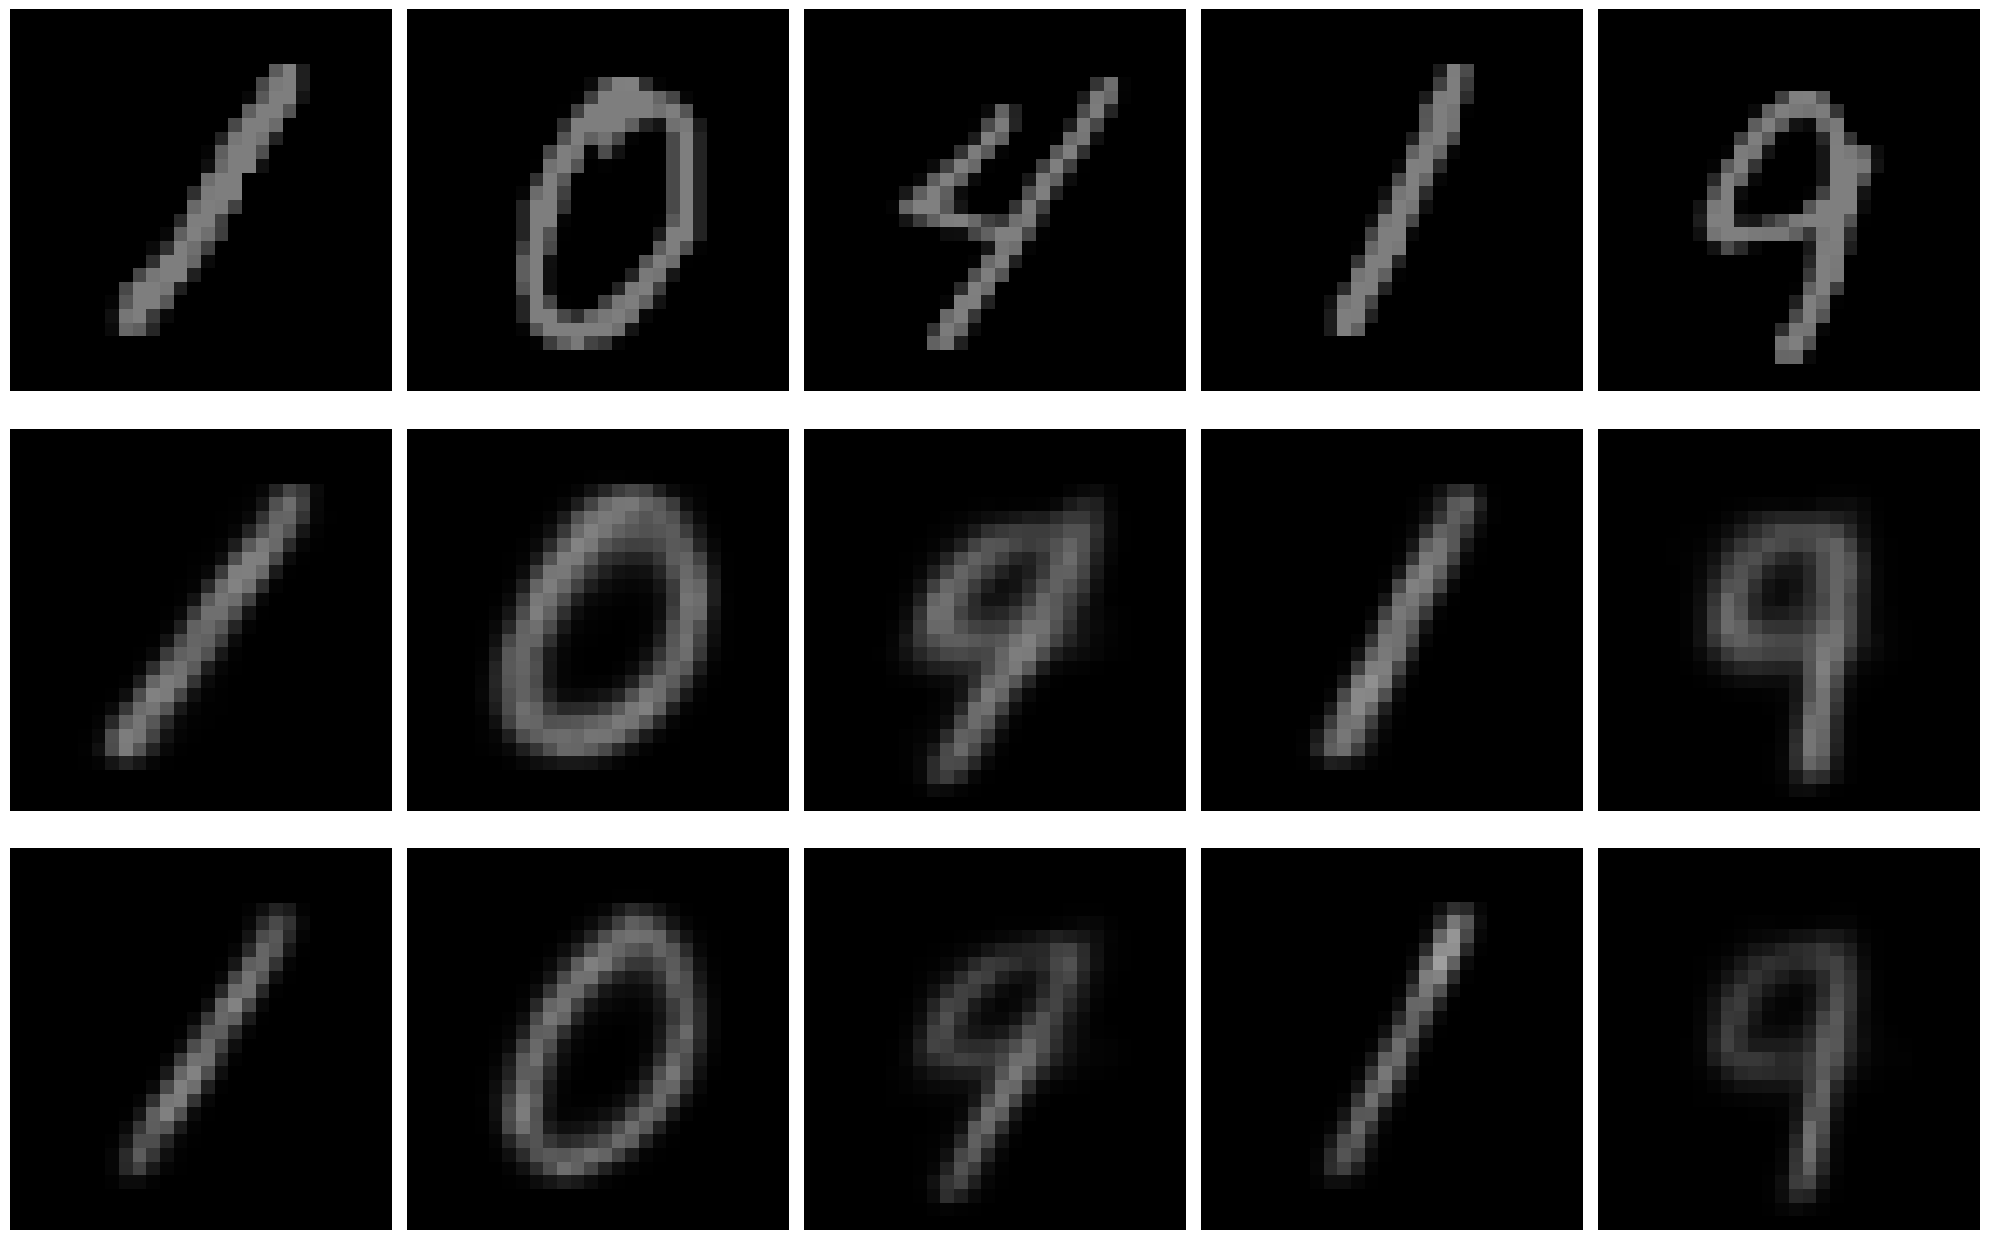

In [13]:
compare_with_vanilla(manager_2, name, 'vanilla 30 v2')

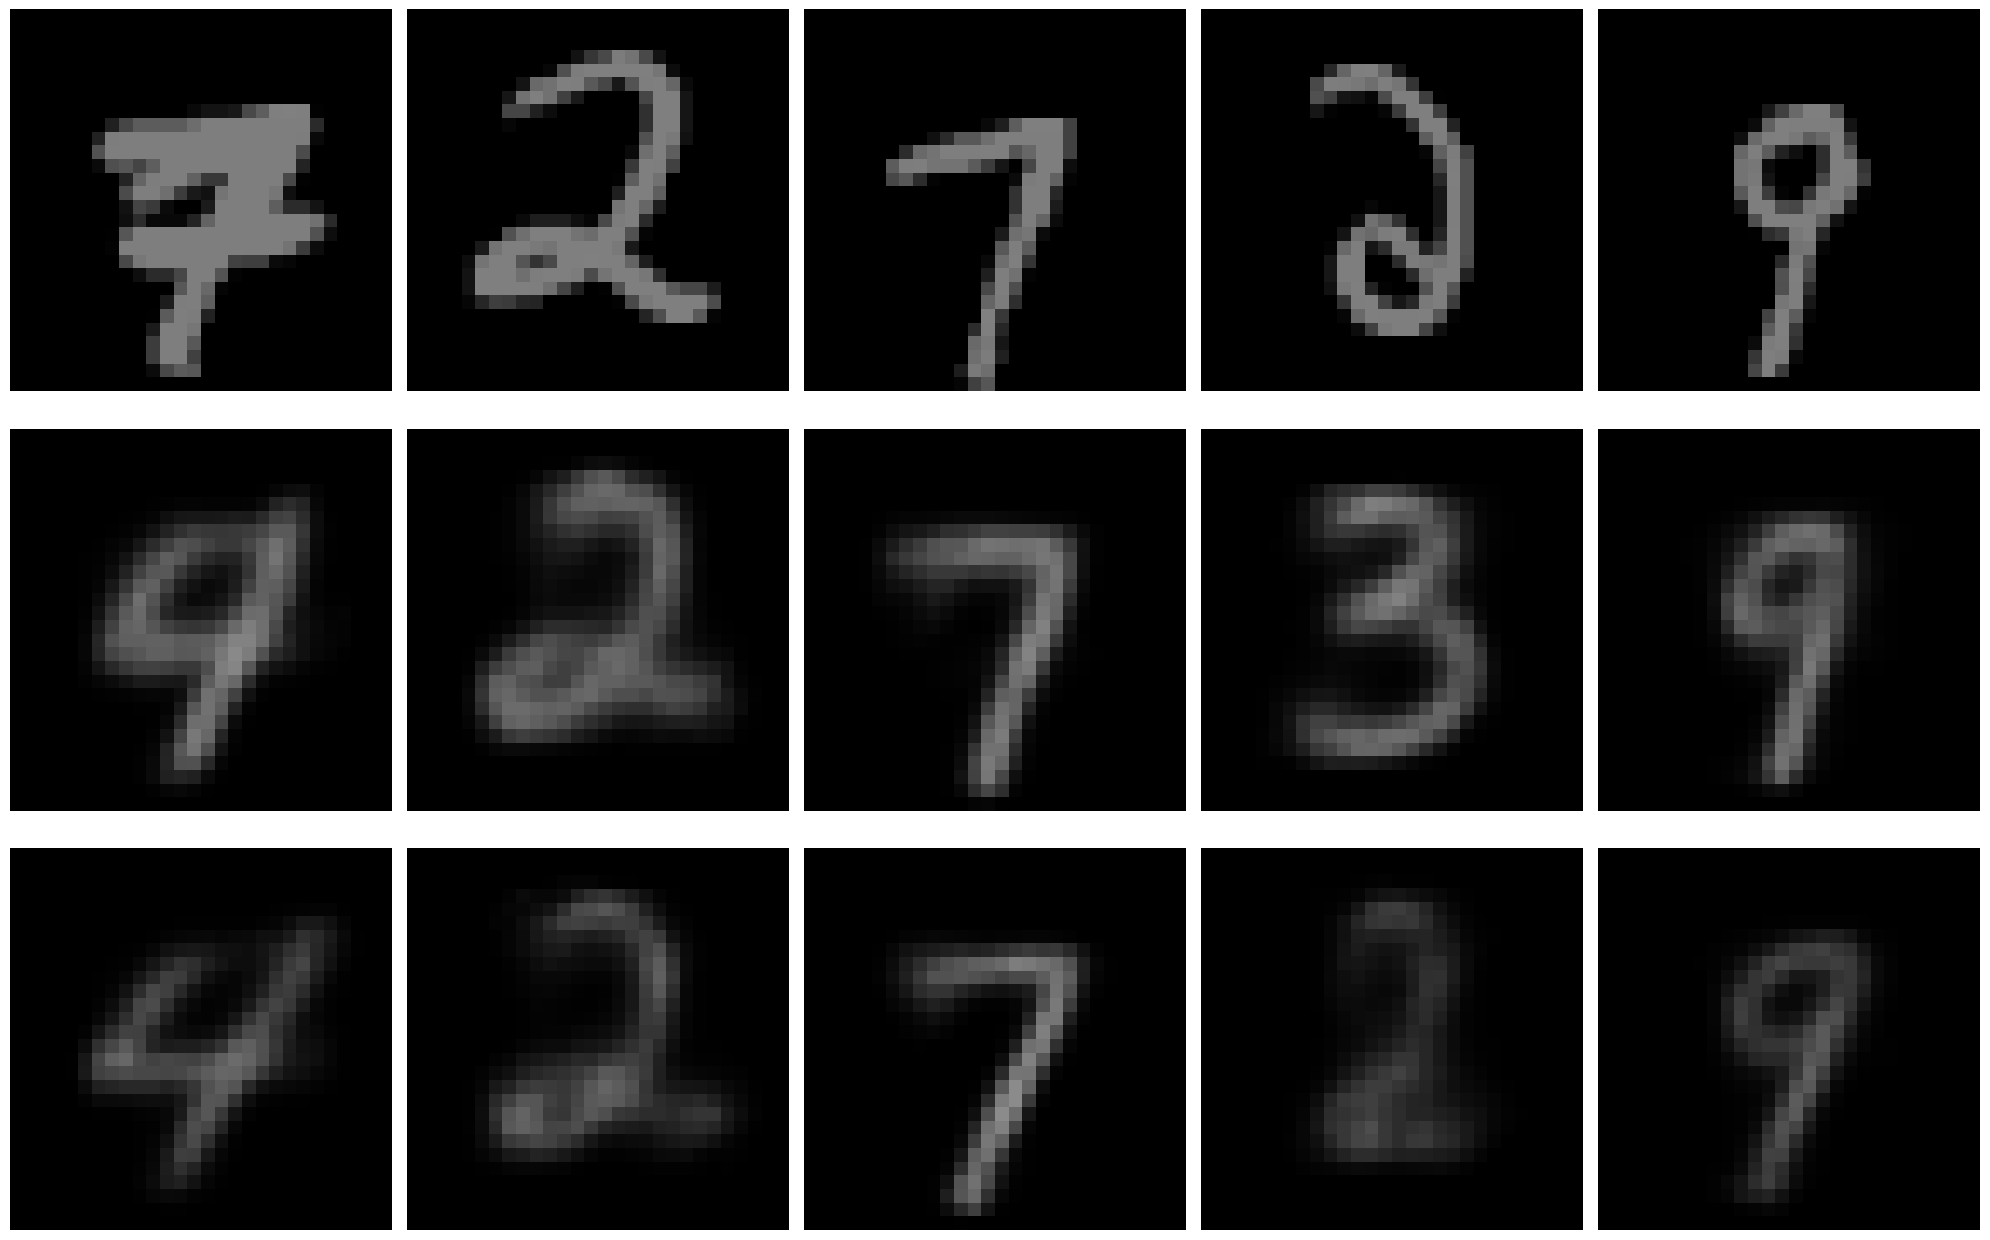

In [16]:
compare_with_vanilla(manager_2, name, 'vanilla 30 v2')

#### ....

Now, it is working on cuda:0.


100%|██████████| 10/10 [01:14<00:00,  7.49s/it]


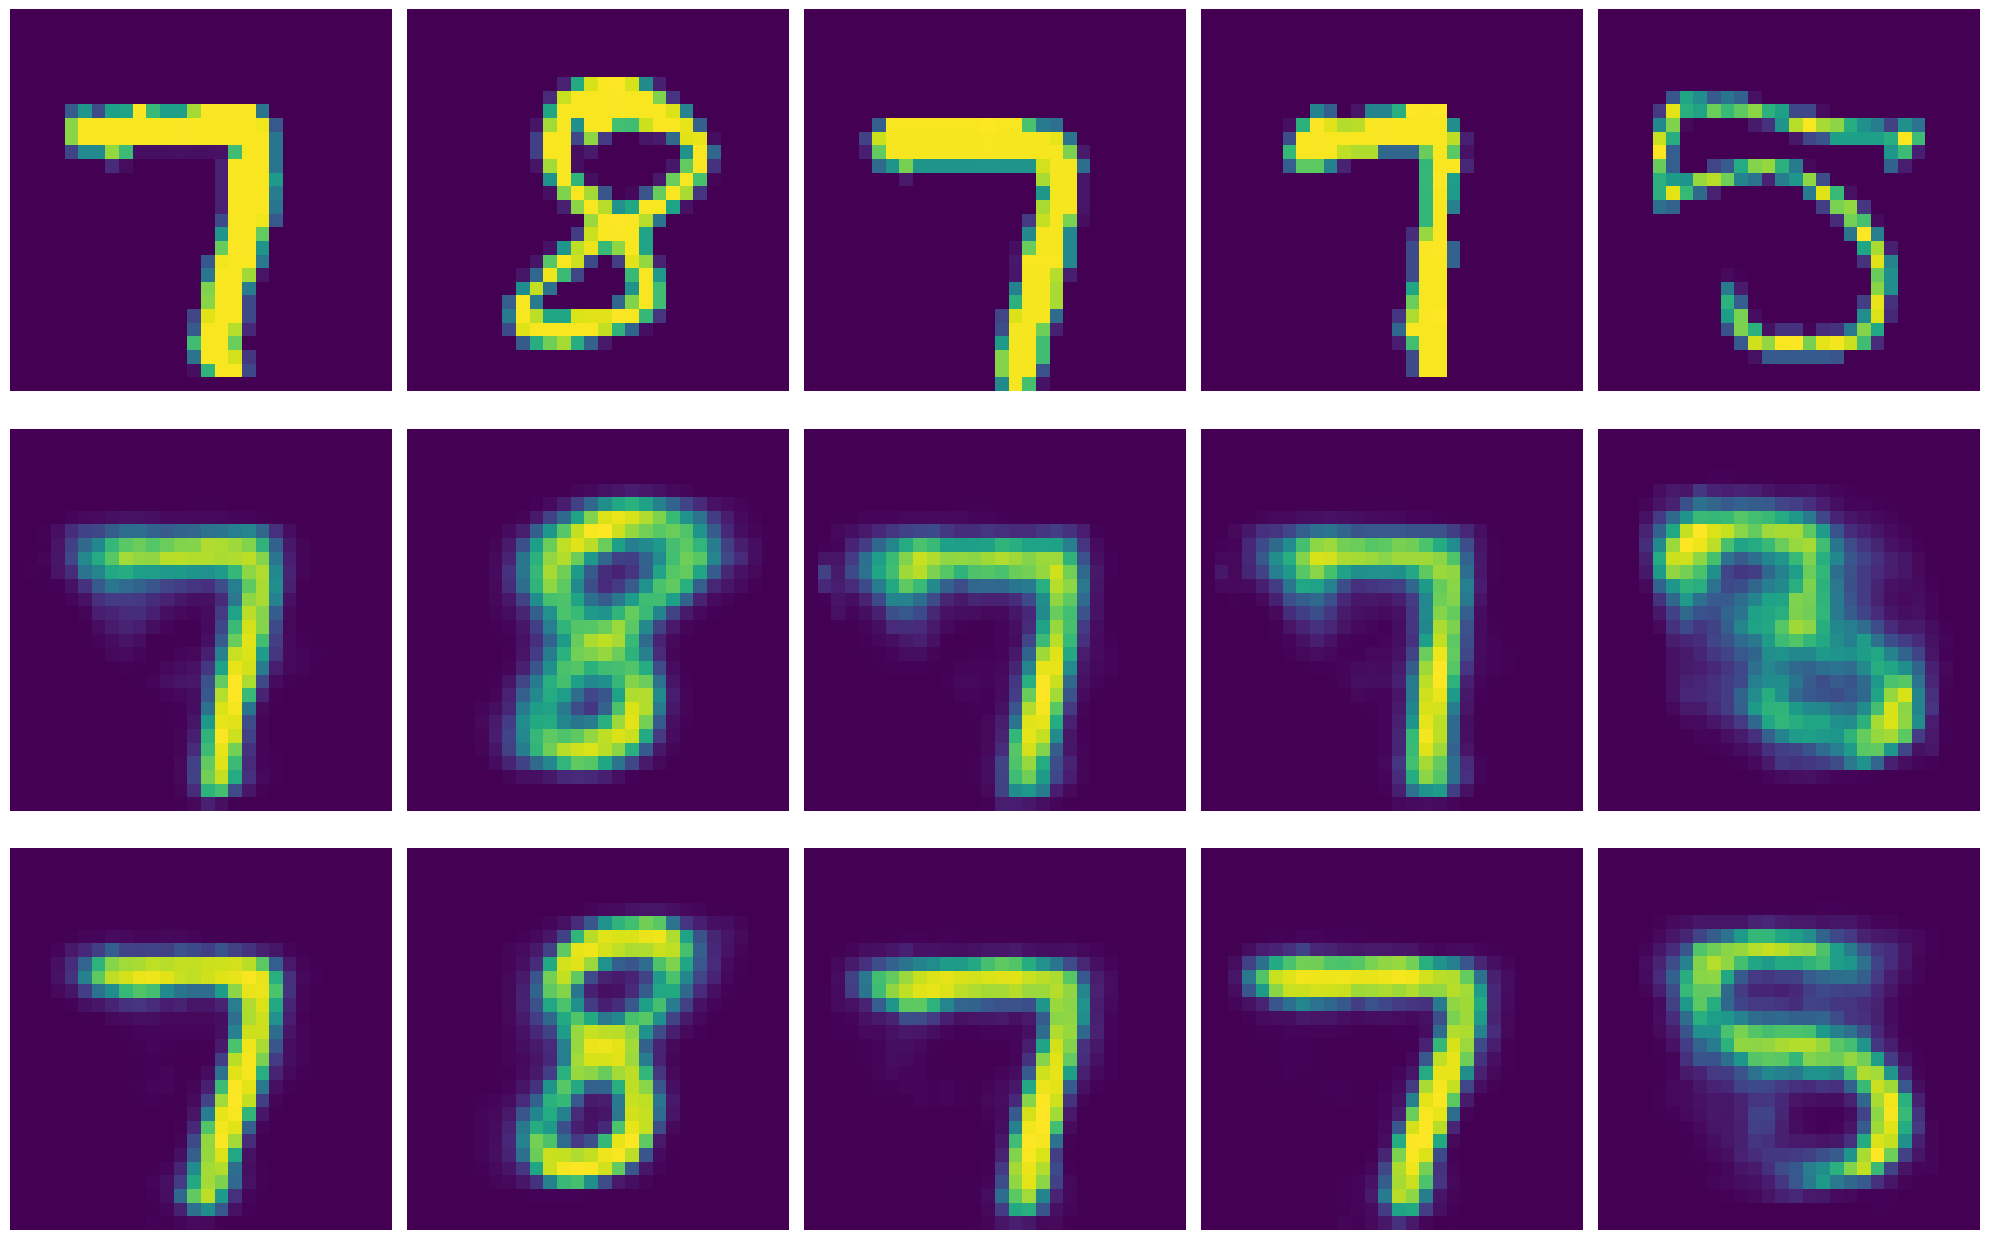

In [16]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    pe = (-(pred - 0.5).square() + 0.25).sum()/len(x) * 1.5
    loss = ll + kl + pe
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=10)
name = 'square 1.5 10'
manager.add_model(name)
compare_with_vanilla(name)

Now, it is working on cuda:0.


100%|██████████| 10/10 [01:15<00:00,  7.59s/it]


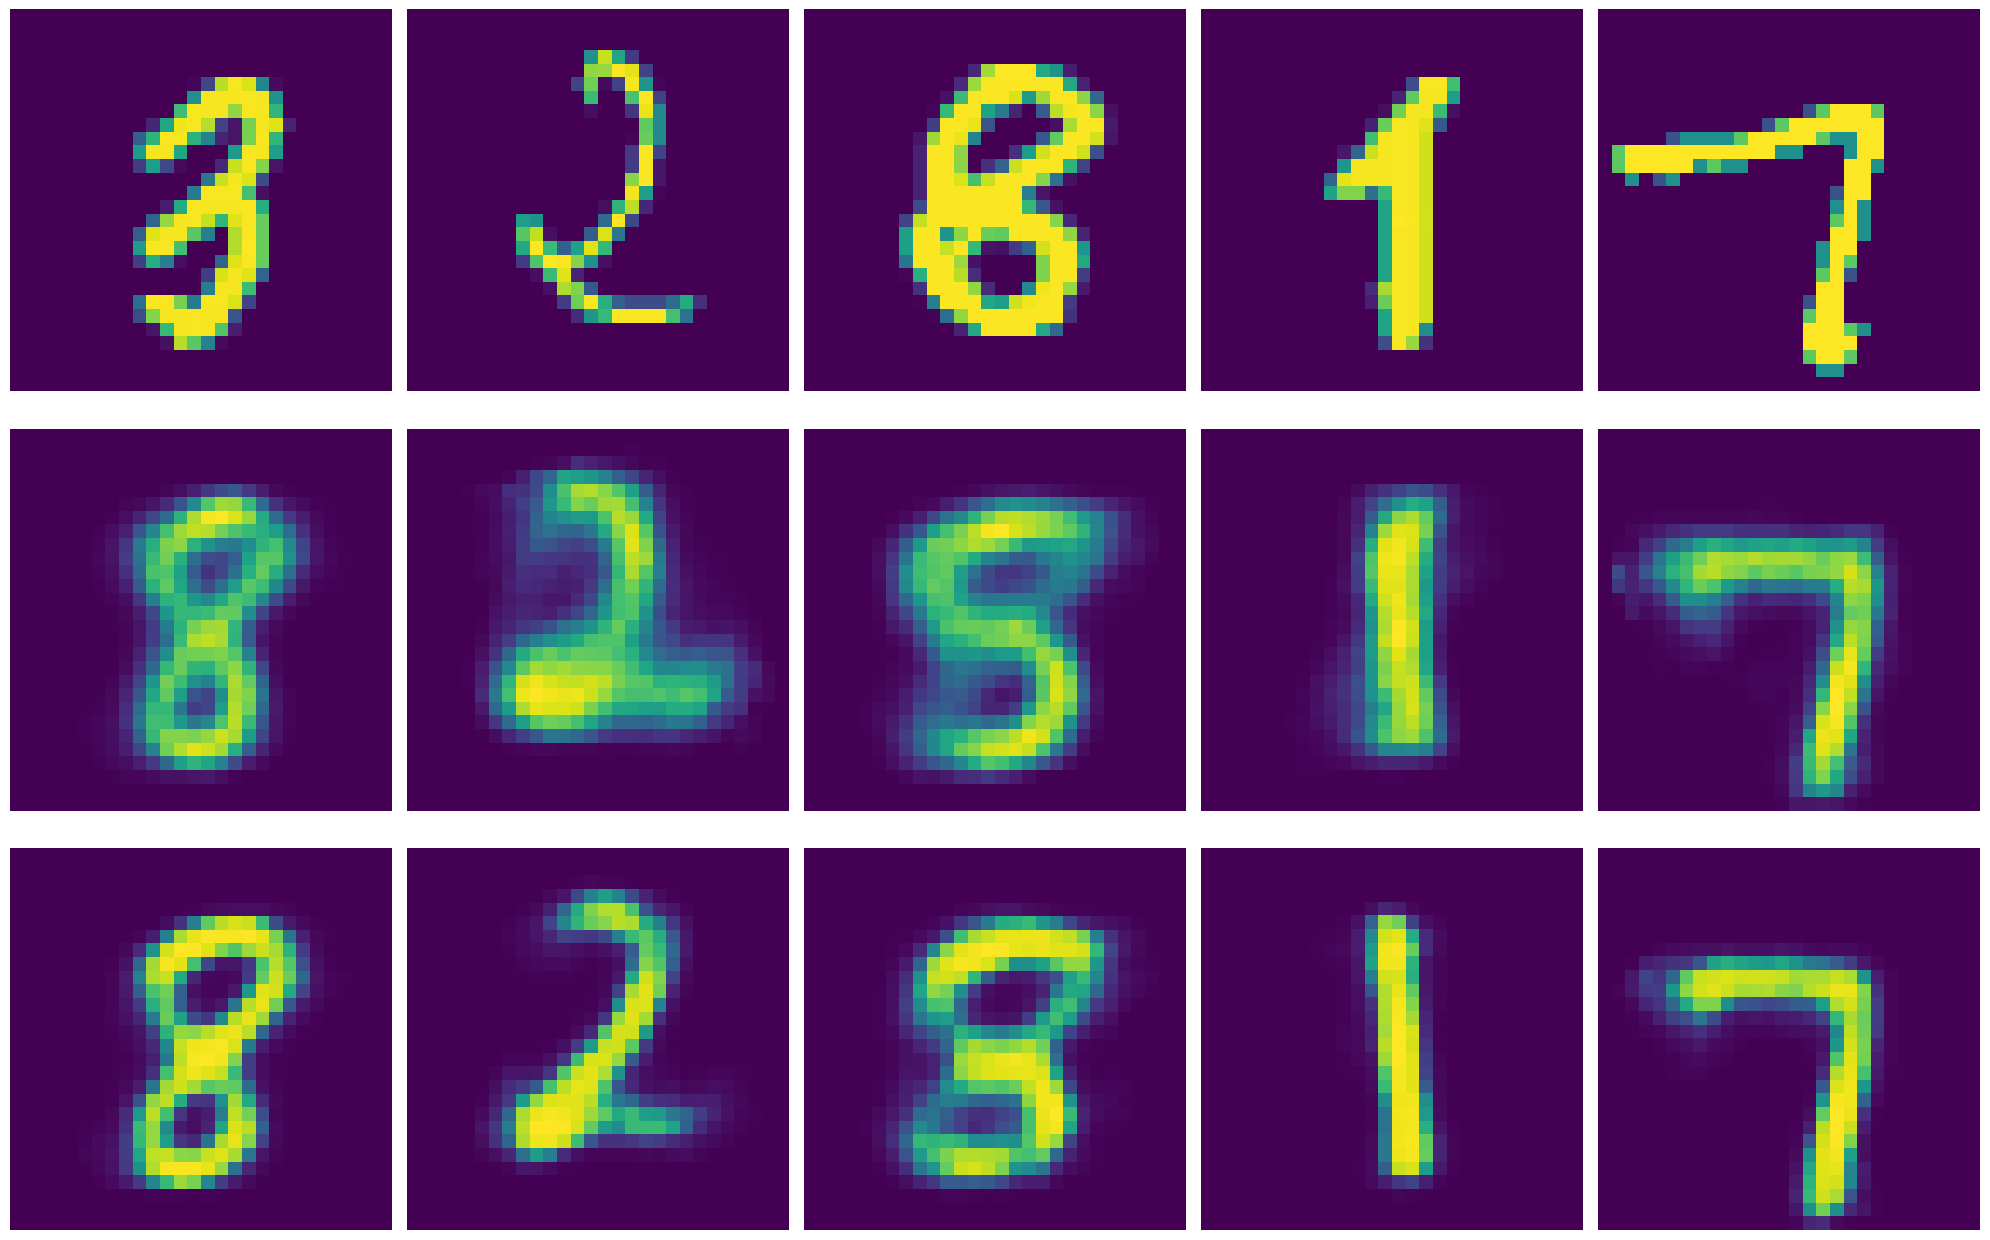

In [17]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    pe = (-(pred - 0.5).square() + 0.25).sum()/len(x) * 2
    loss = ll + kl + pe
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=10)
name = 'square 2 10'
manager.add_model(name)
compare_with_vanilla(name)

Now, it is working on cuda:0.


100%|██████████| 10/10 [01:15<00:00,  7.54s/it]


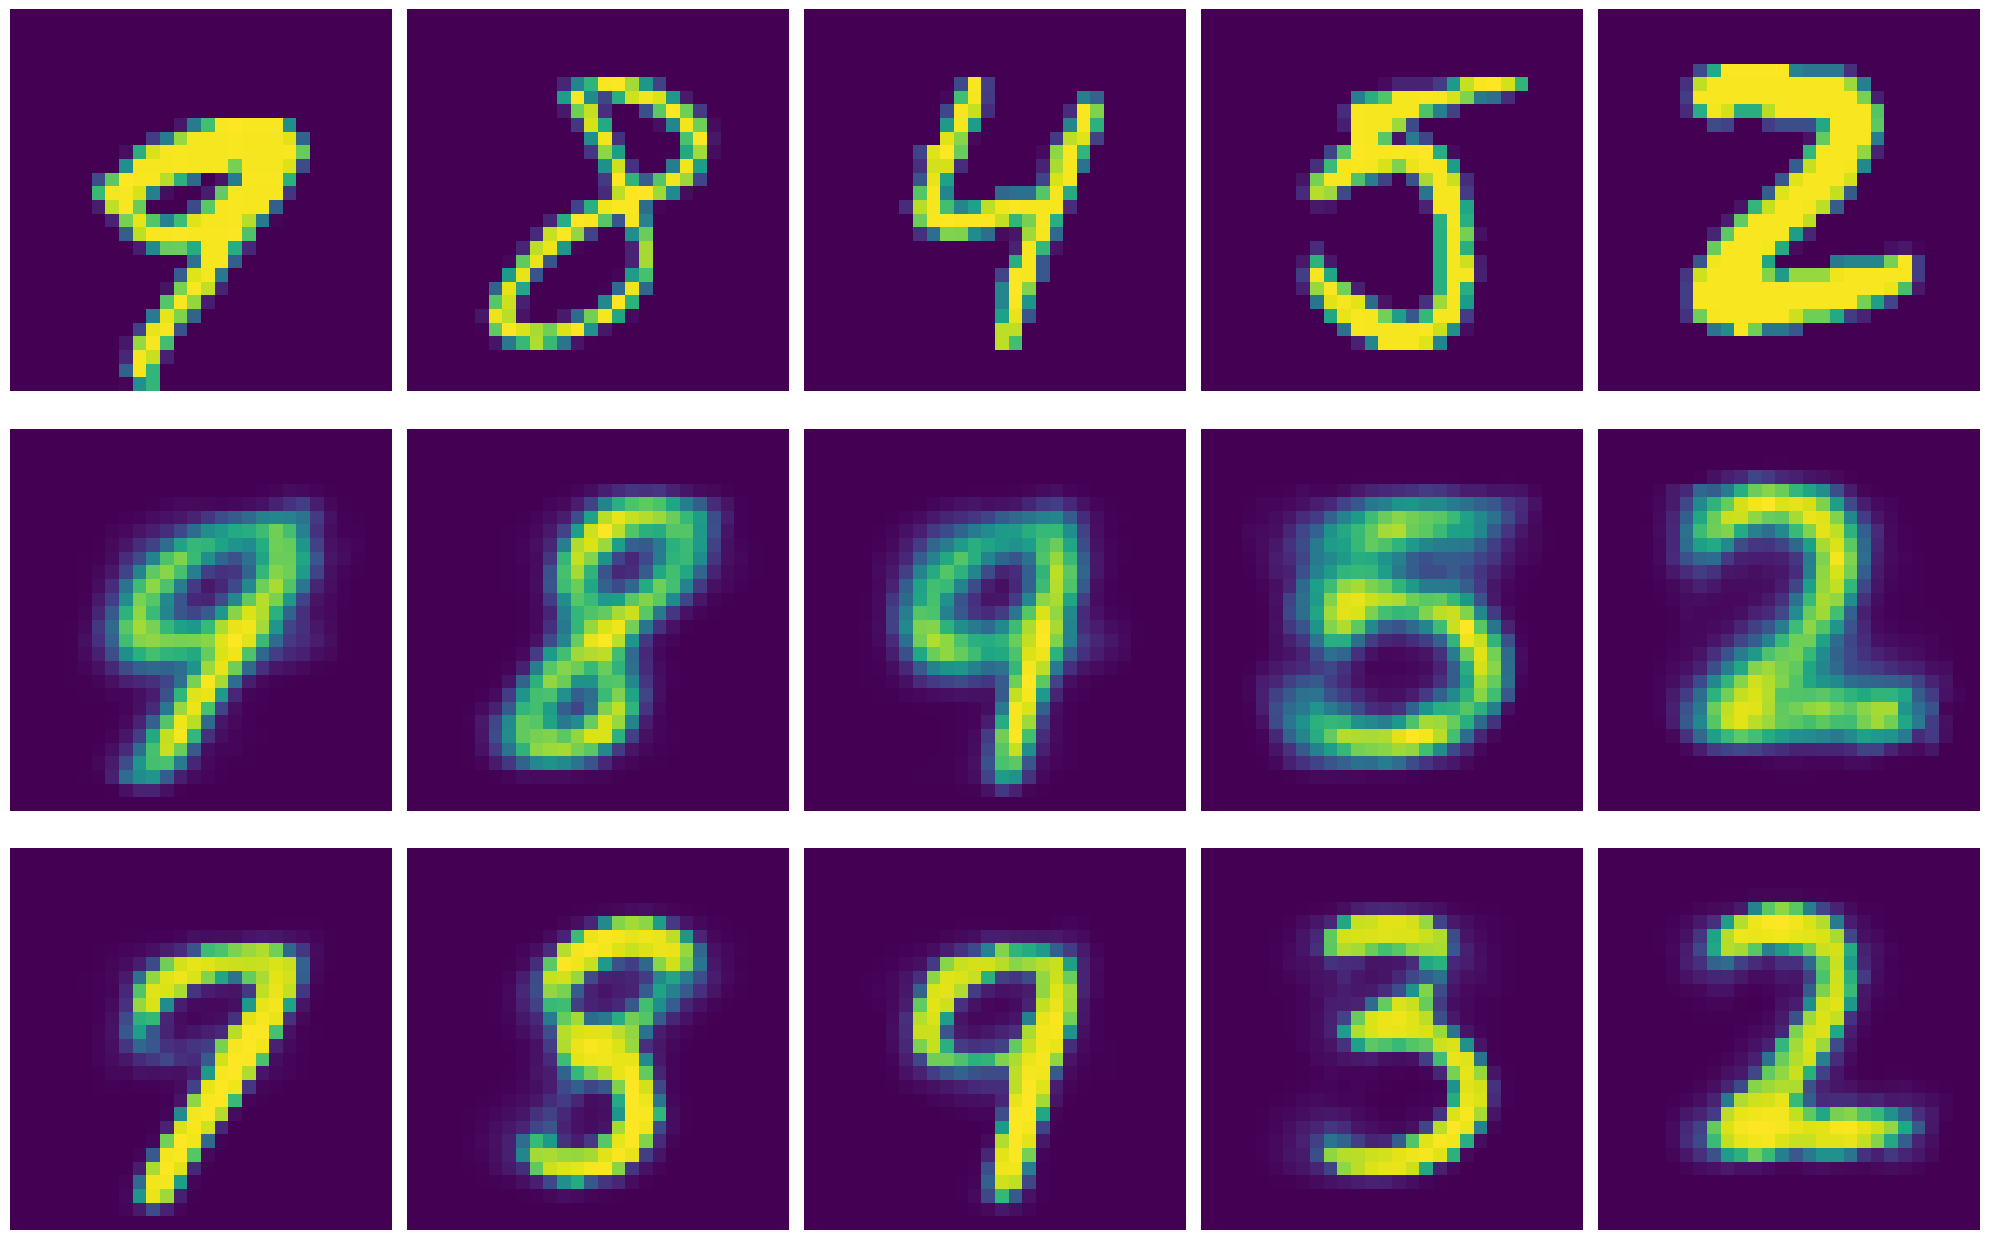

In [19]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    pe = (-(pred - 0.5).square() + 0.25).sum()/len(x) * 3
    loss = ll + kl + pe
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=10)
name = 'square 3 10'
manager.add_model(name)
compare_with_vanilla(name)

Now, it is working on cuda:0.


100%|██████████| 10/10 [01:16<00:00,  7.68s/it]


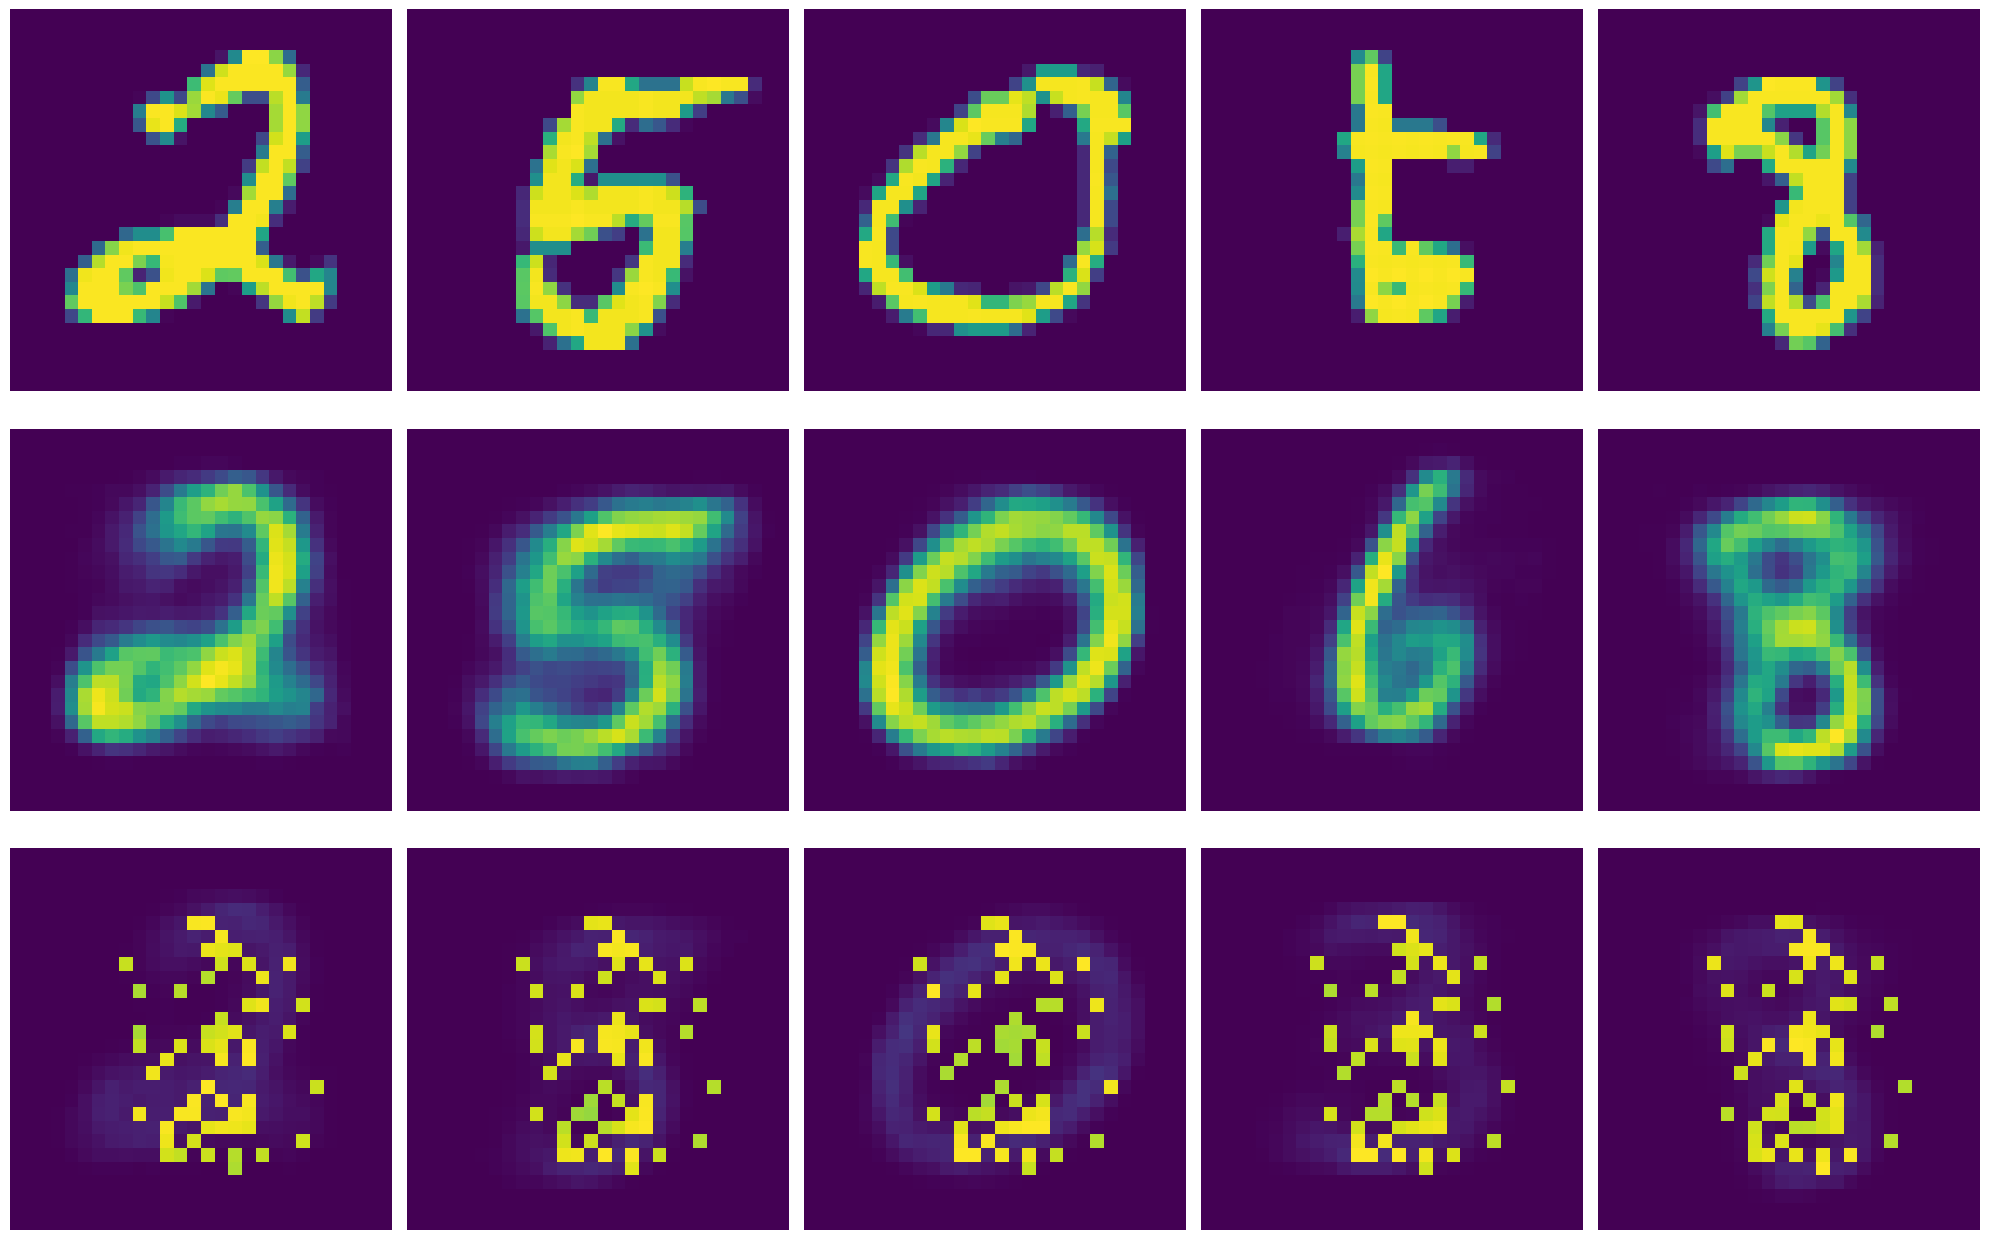

In [18]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    pe = (-(pred - 0.5).square() + 0.25).sum()/len(x) * 10
    loss = ll + kl + pe
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=10)
name = 'square 10 10'
manager.add_model(name)
compare_with_vanilla(name)

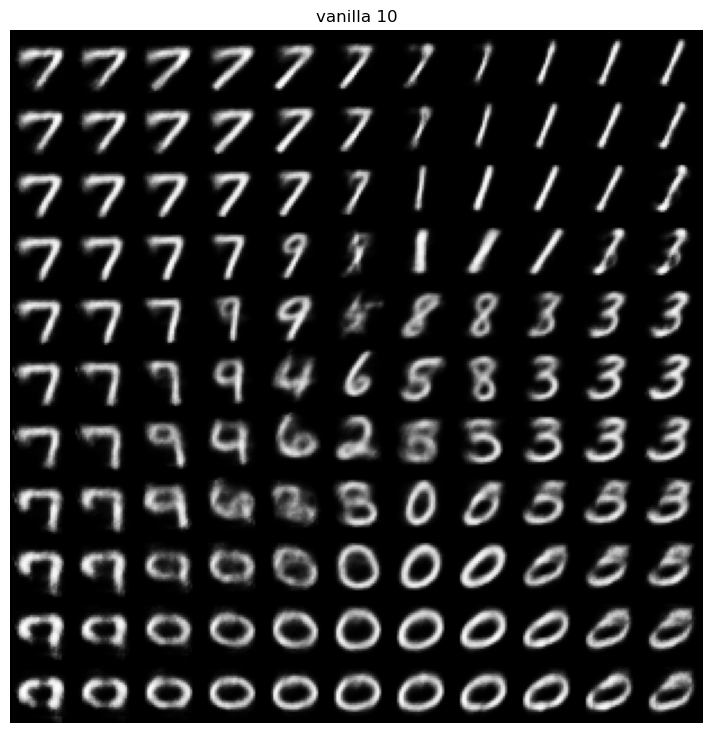

In [23]:
name = 'vanilla 10'
manager.swap_current_model(name)
manager.plot_generated_images(name)

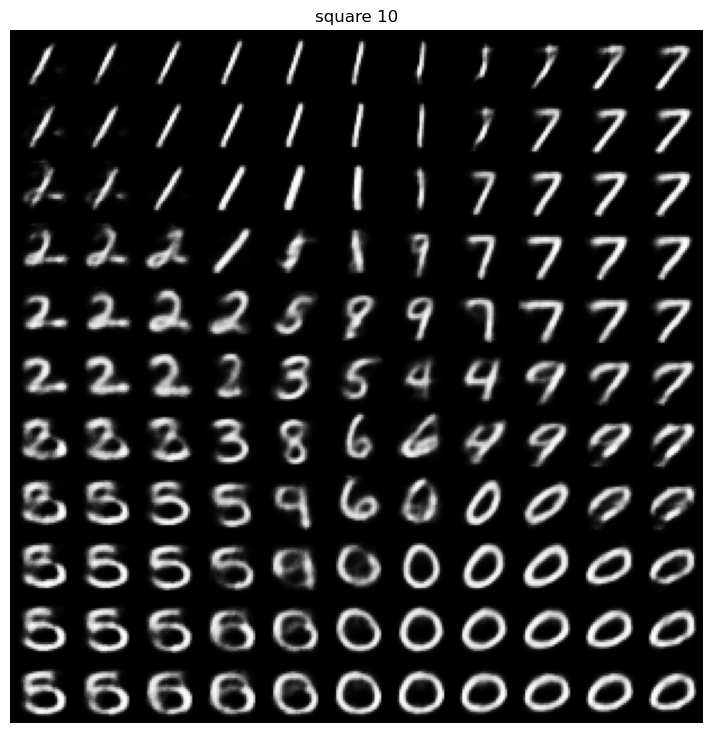

In [29]:
name = 'square 10'
manager.swap_current_model(name)
manager.plot_generated_images(name)

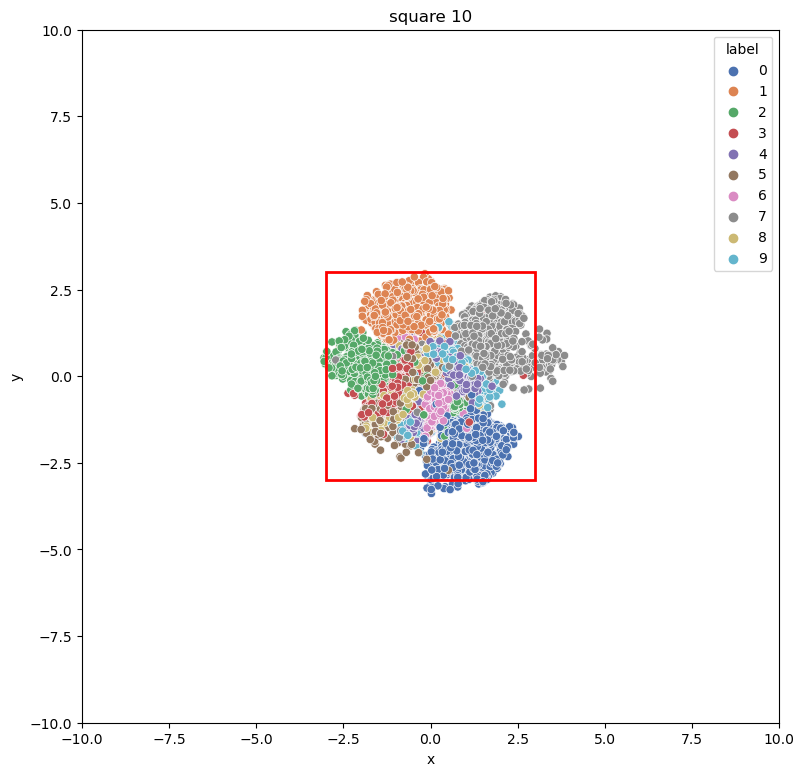

In [30]:
def encode(model, x, y):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    return [mu]

manager.show_latent_space(name, encode)

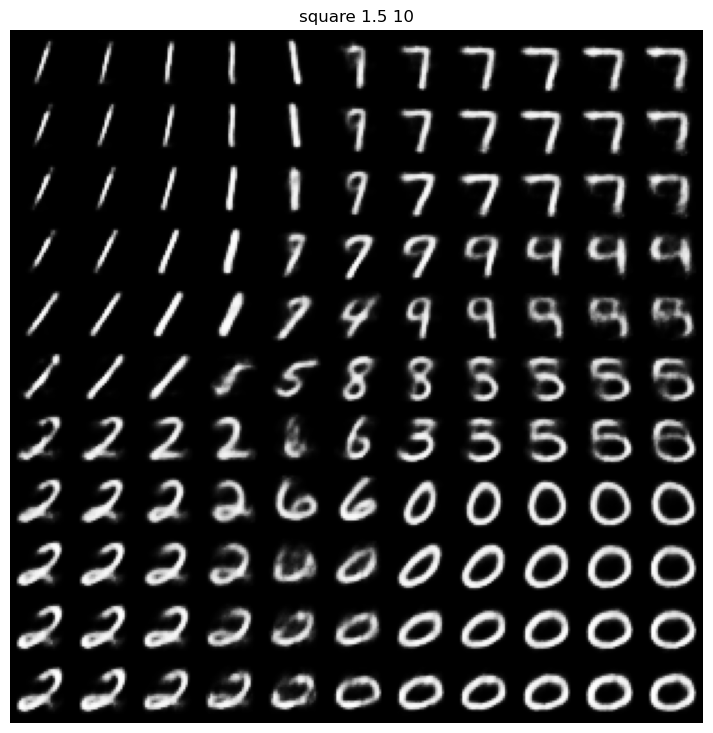

In [24]:
name = 'square 1.5 10'
manager.swap_current_model(name)
manager.plot_generated_images(name)

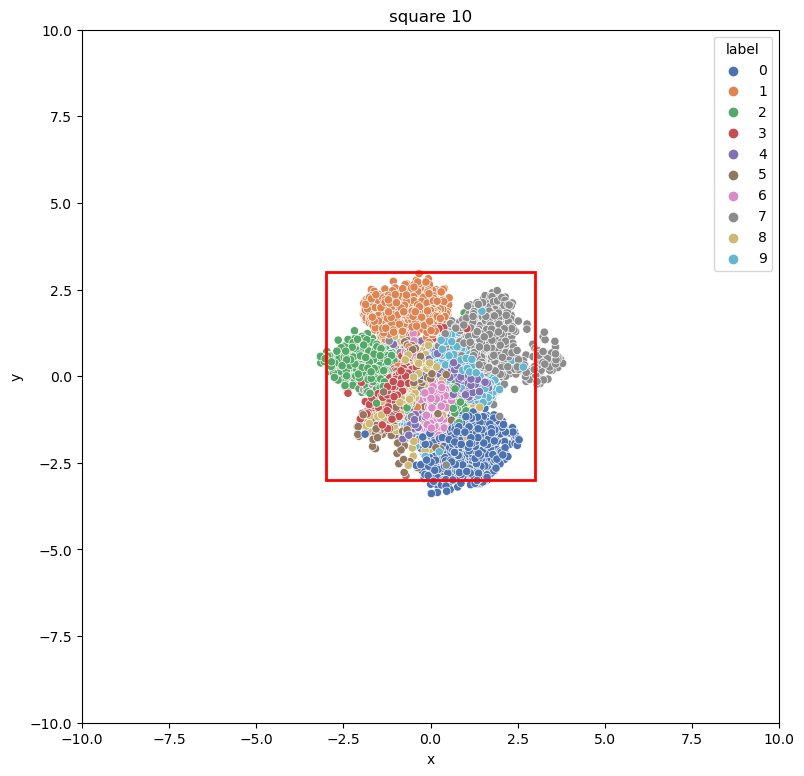

In [28]:
def encode(model, x, y):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    return [mu]

manager.show_latent_space(name, encode)

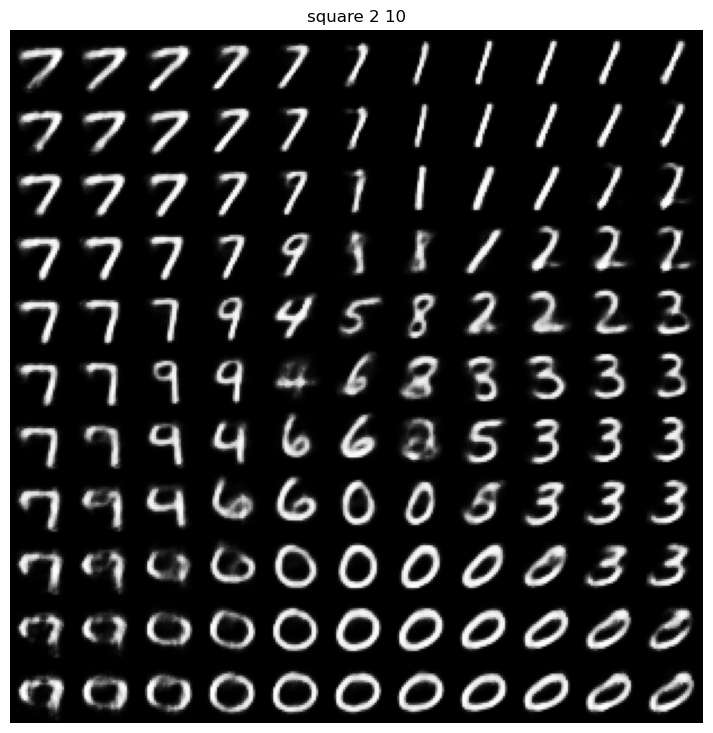

In [25]:
name = 'square 2 10'
manager.swap_current_model(name)
manager.plot_generated_images(name)

In [20]:
import math
math.pi

3.141592653589793

Now, it is working on cuda:0.


100%|██████████| 10/10 [01:15<00:00,  7.59s/it]


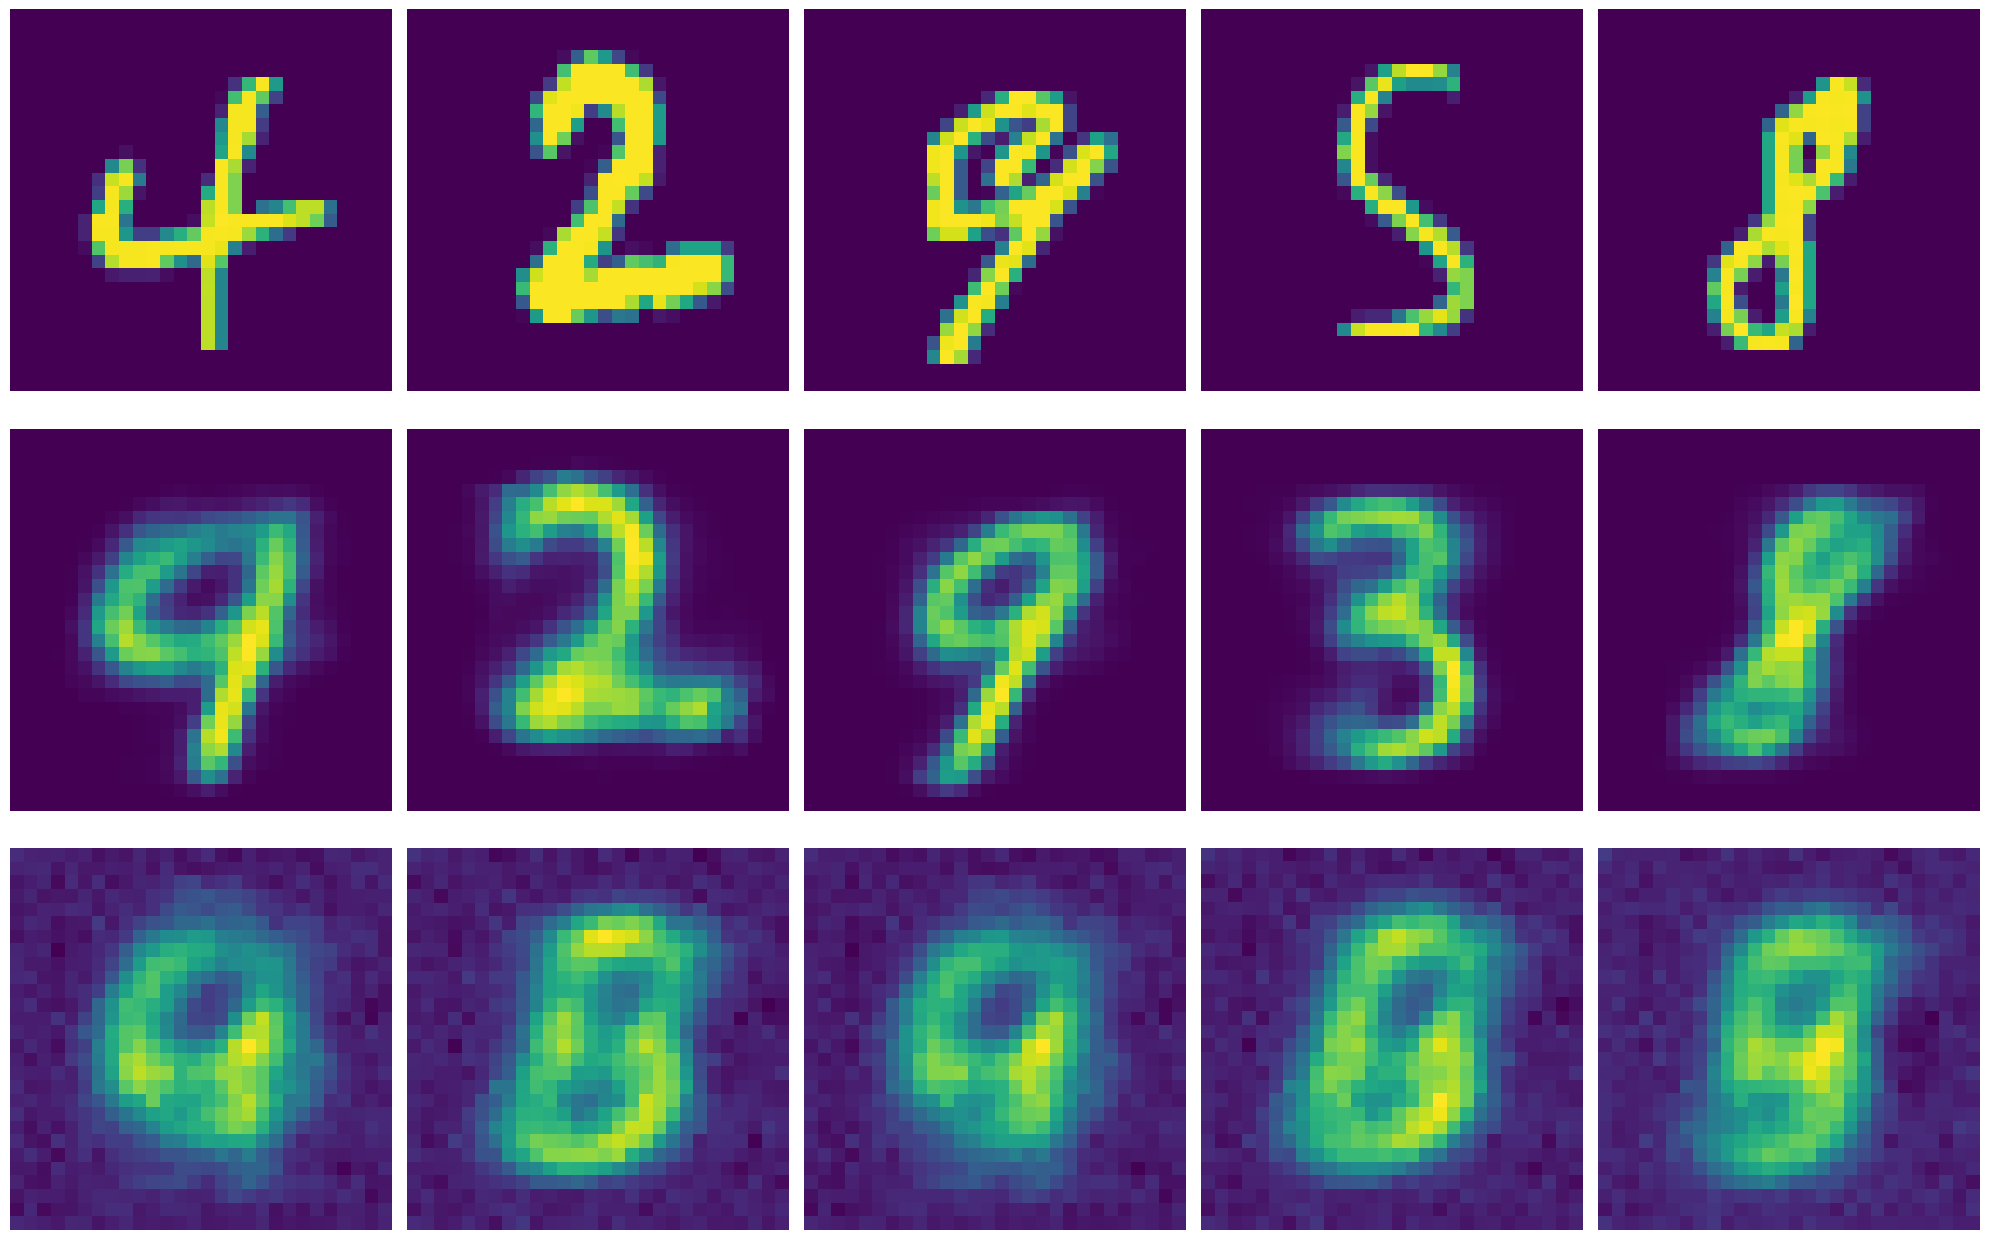

In [21]:


def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    pe = ((pred * 4 * math.pi - math.pi / 2).sin() + 1).sum()/len(x)
    loss = ll + kl + pe
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=10)
name = 'sin 10'
manager.add_model(name)
compare_with_vanilla(name)

Now, it is working on cuda:0.


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:33<00:00,  9.31s/it]


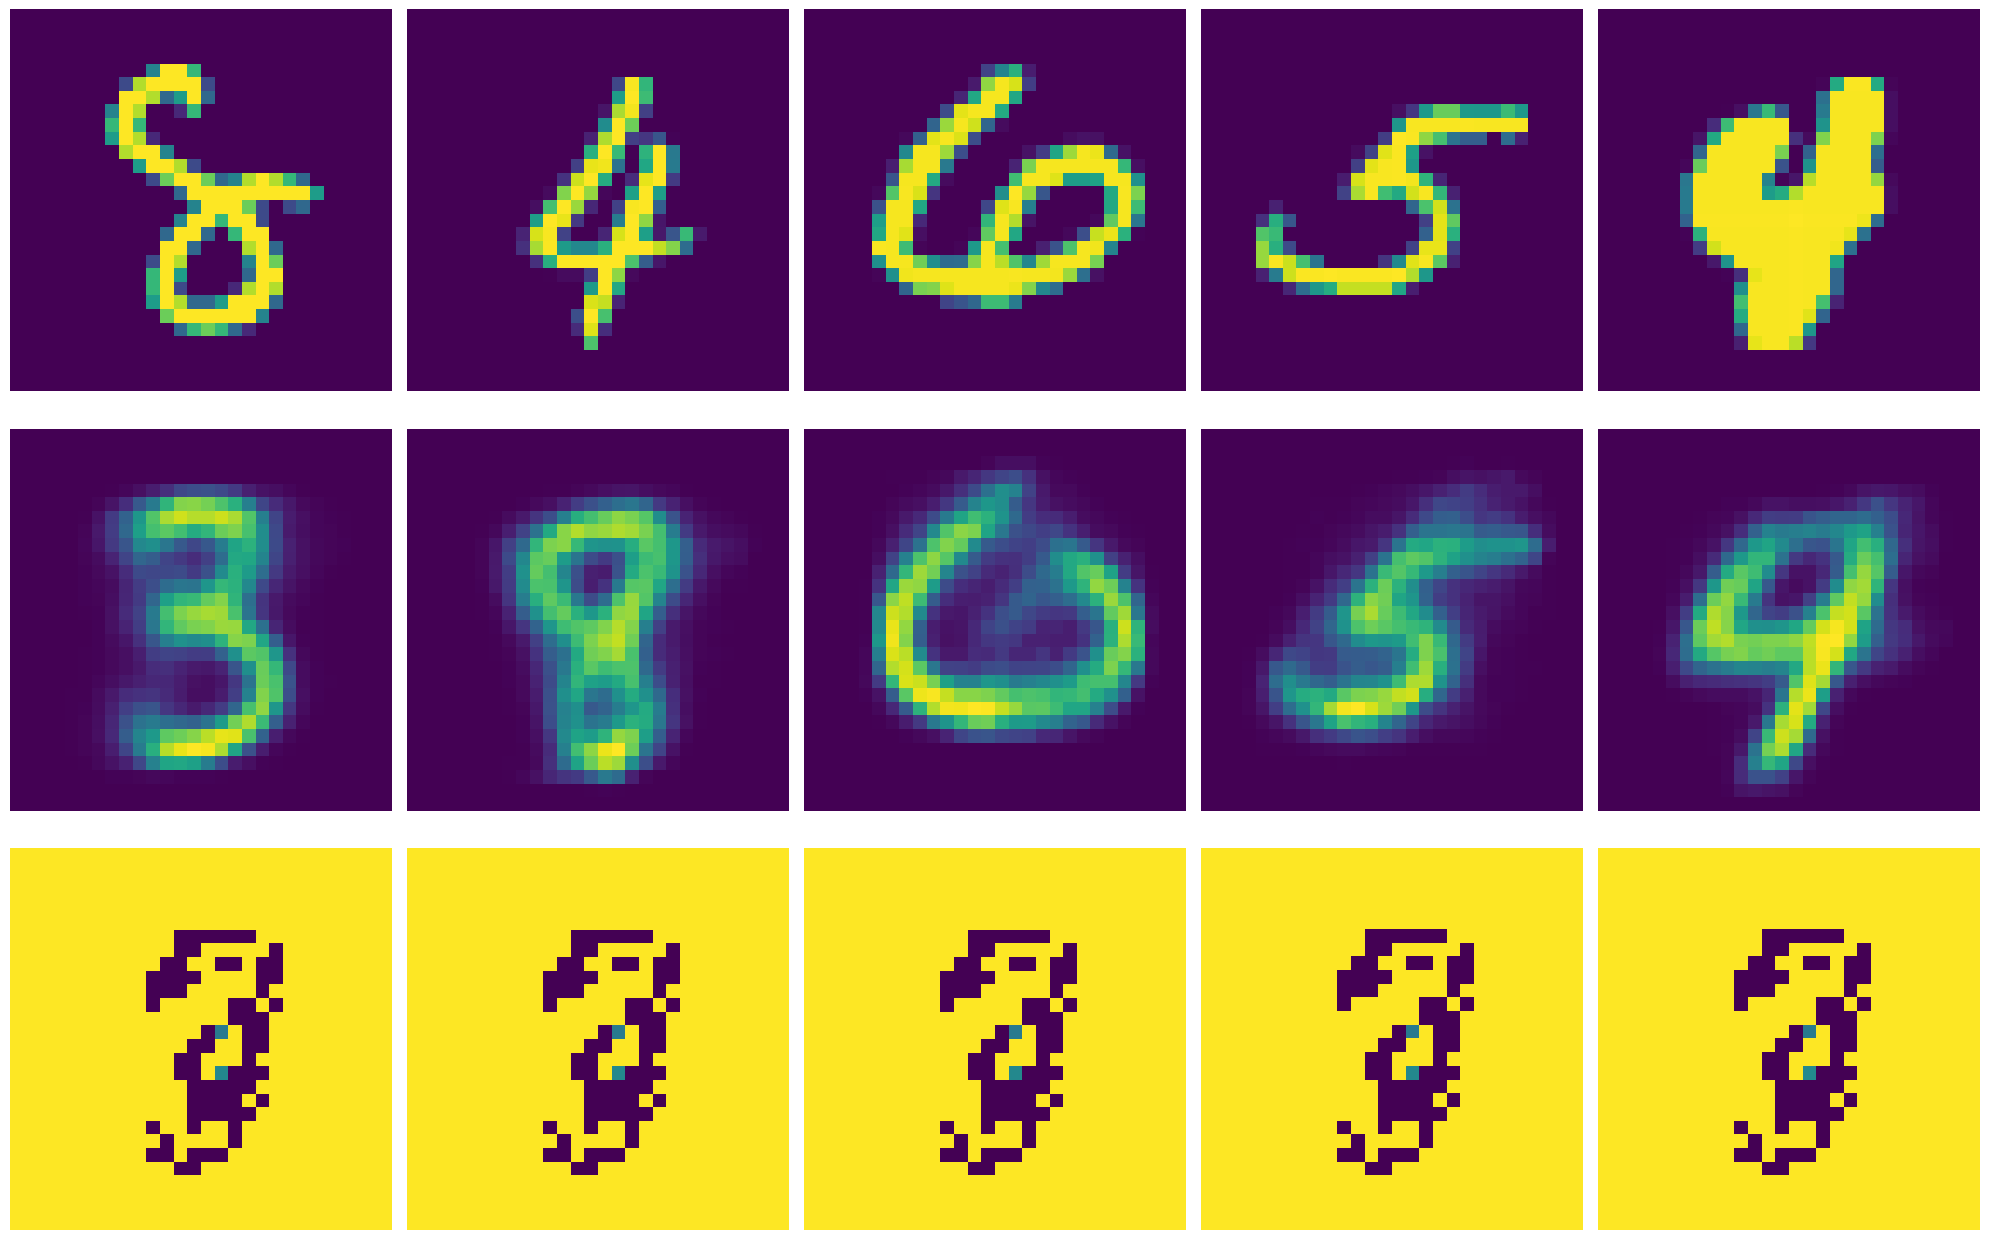

In [18]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    ms = (pred - x).square()
    pe = -ms[ms > 0.5].log().sum()
    loss = ll + kl + pe
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=10)
name = 'pe 0.5 10'
manager.add_model(name)
compare_with_vanilla(name)

In [29]:
tmp = torch.rand(10, 1, 5, 7)
torch.div(tmp, tmp.sum(dim=[1,2,3]).view([-1, 1]))

RuntimeError: The size of tensor a (5) must match the size of tensor b (10) at non-singleton dimension 2

In [24]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    ms = (pred - x).square()
    msm = ms / ms.sum(dim=[1, 2, 3])
    pe = -msm.log().sum()
    loss = ll + kl + pe
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=10)
name = 'pe prop 10'
manager.add_model(name)
compare_with_vanilla(name)

Now, it is working on cuda:0.


  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (28) must match the size of tensor b (128) at non-singleton dimension 3

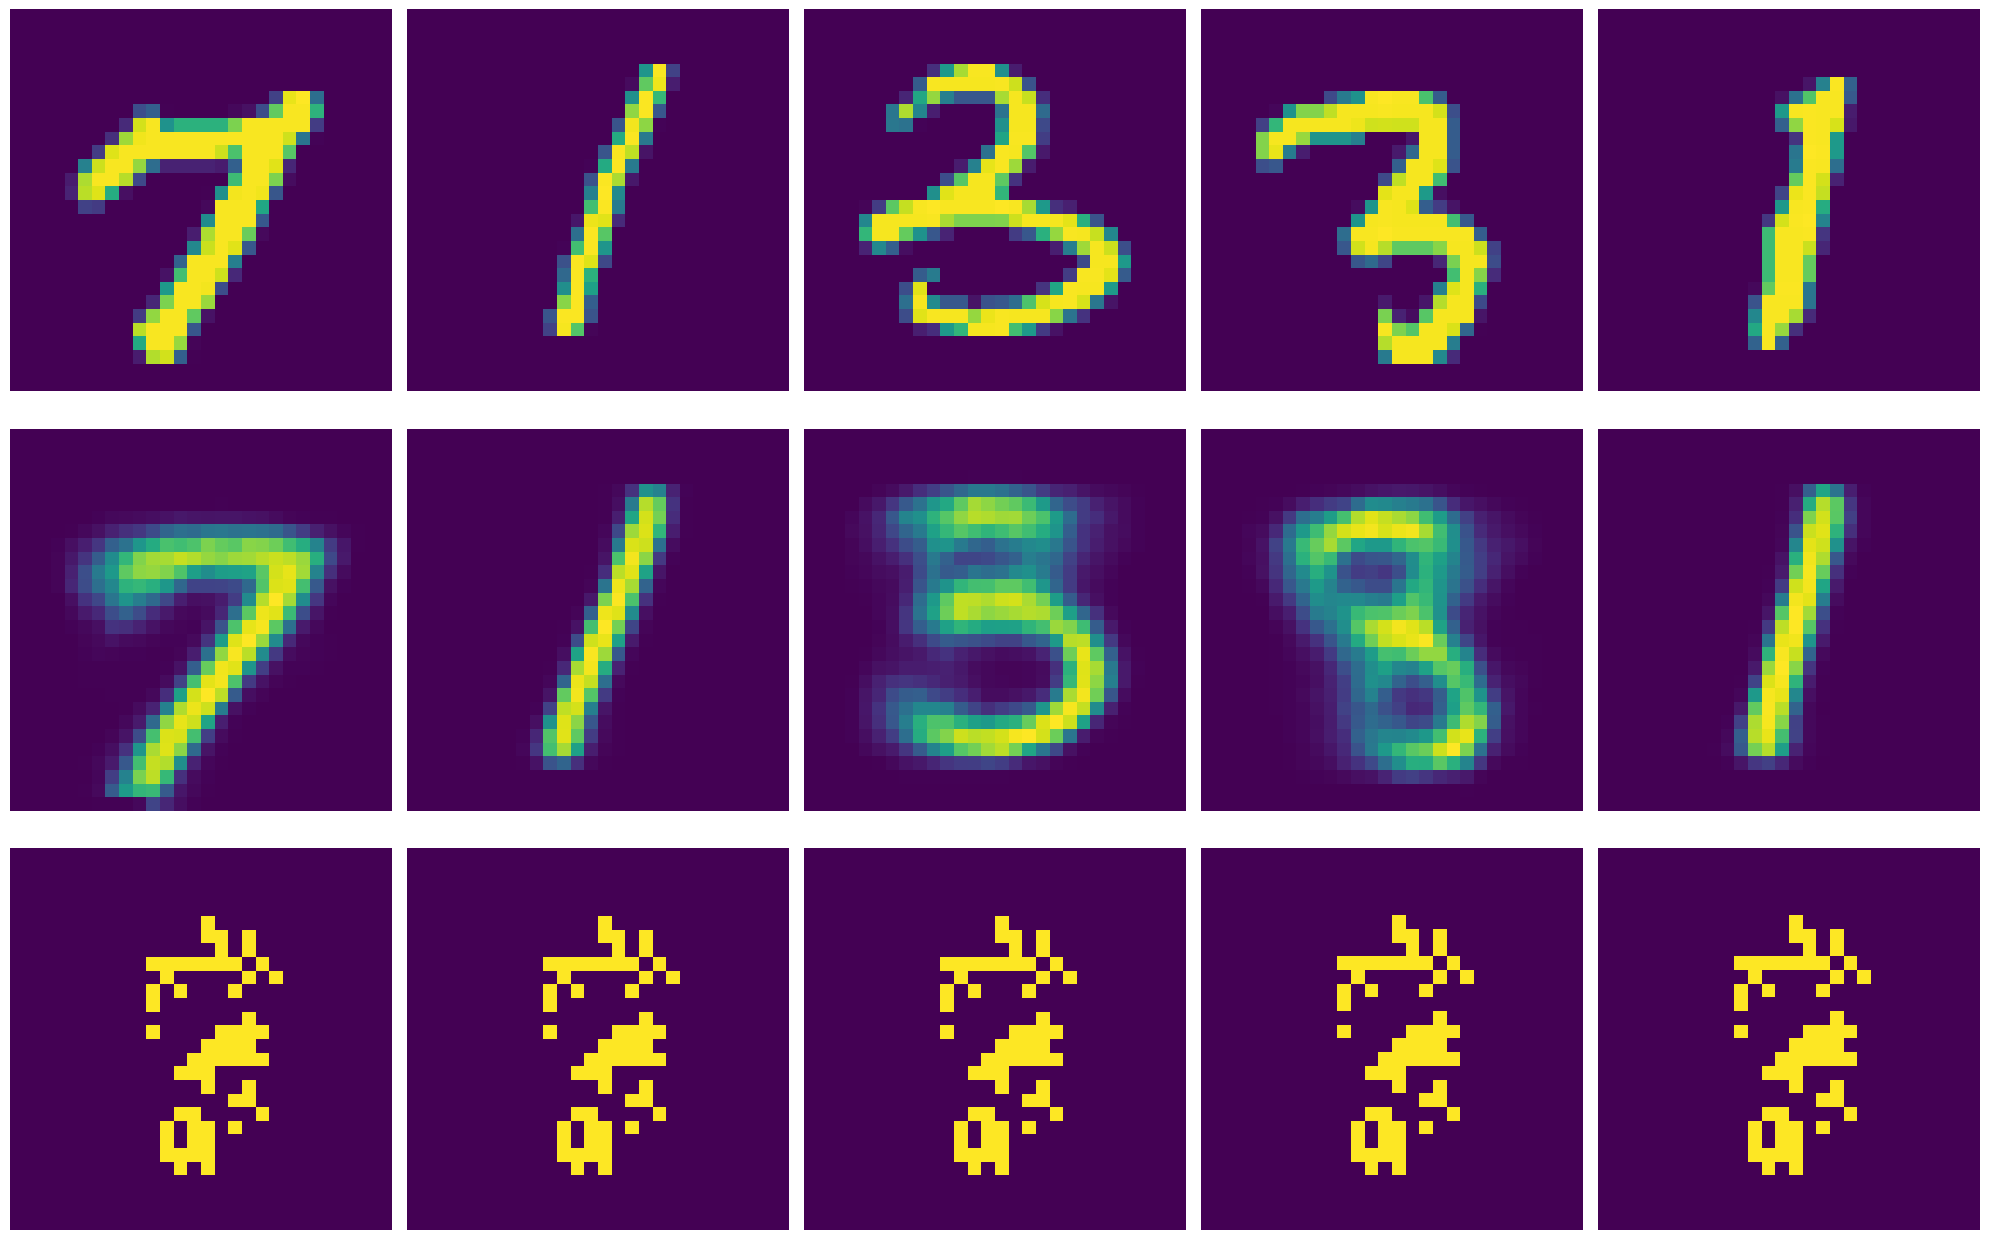

In [15]:
fig, (axs1, axs2, axs3) = plt.subplots(nrows=3, ncols=5, figsize=[20, 13])

manager.swap_current_model('vanilla 10')
manager.model.to('cpu')
manager.model.eval()

for x, y in manager.train_dataloader:
    with torch.no_grad():
        h = manager.model.get_submodule("encoder")(x)
        mu = h[:, :2]
        x_hats = manager.model.get_submodule("decoder")(mu)
    for ax, img in zip(axs1, x[:5]):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    for ax, img in zip(axs2, x_hats):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')

    
    with torch.no_grad():
        manager.swap_current_model('pixel_entropy - 10')

        manager.model.to('cpu')
        manager.model.eval()

        h = manager.model.get_submodule("encoder")(x)
        mu = h[:, :2]
        x_hats = manager.model.get_submodule("decoder")(mu)
    for ax, img in zip(axs3, x_hats):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    
    break
plt.tight_layout()

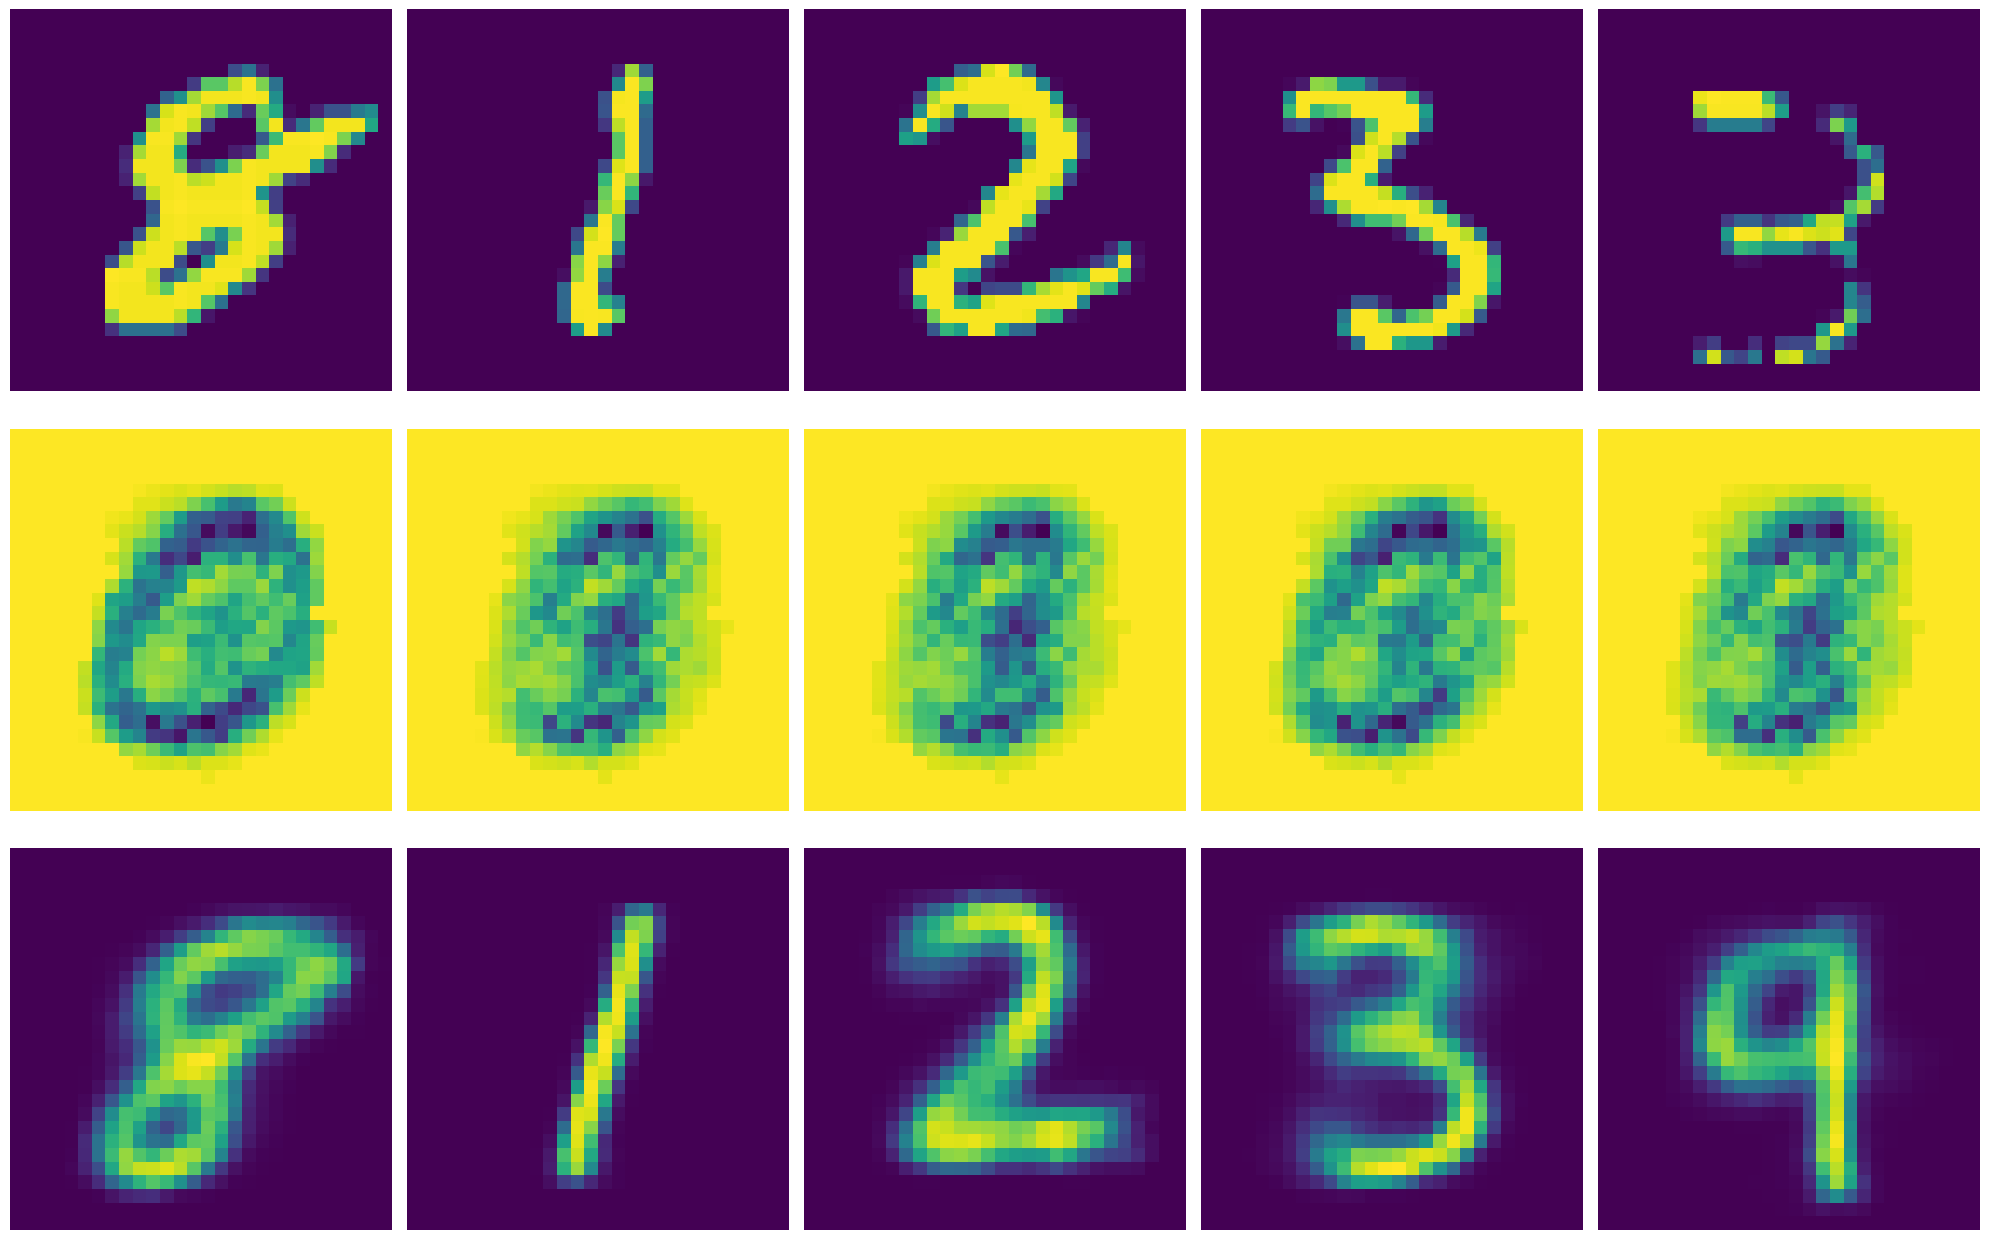

In [13]:
fig, (axs1, axs2, axs3) = plt.subplots(nrows=3, ncols=5, figsize=[20, 13])

manager.swap_current_model('vanilla 10')
manager.model.to('cpu')
manager.model.eval()

for x, y in manager.train_dataloader:
    with torch.no_grad():
        h = manager.model.get_submodule("encoder")(x)
        mu = h[:, :2]
        x_hats = manager.model.get_submodule("decoder")(mu)
    for ax, img in zip(axs1, x[:5]):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    for ax, img in zip(axs2, x_hats):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')

    
    with torch.no_grad():
        manager.swap_current_model('vanilla 10')

        manager.model.to('cpu')
        manager.model.eval()

        h = manager.model.get_submodule("encoder")(x)
        mu = h[:, :2]
        x_hats = manager.model.get_submodule("decoder")(mu)
    for ax, img in zip(axs3, x_hats):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    
    break
plt.tight_layout()

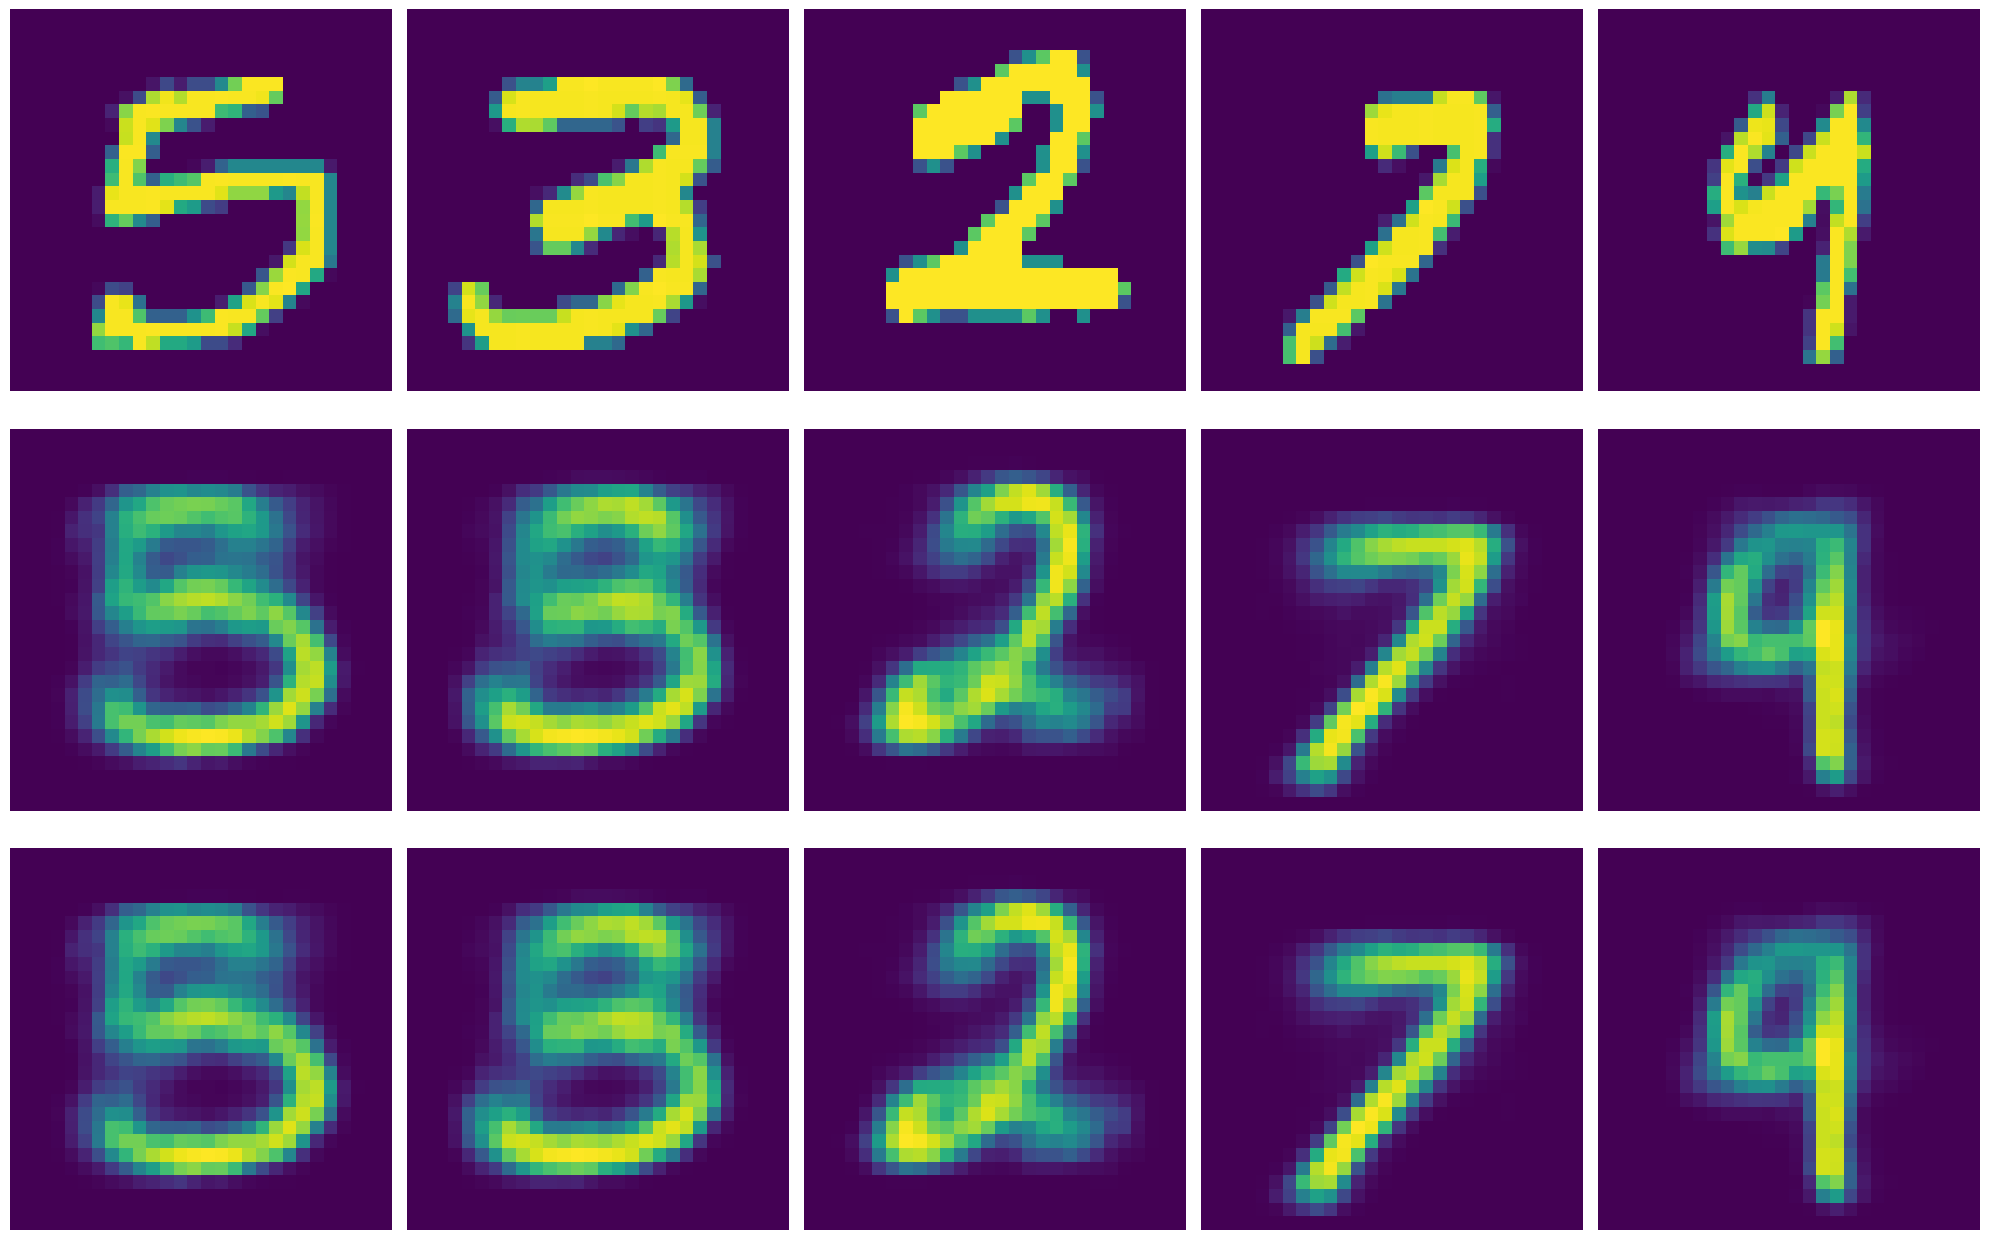

In [10]:
fig, (axs1, axs2, axs3) = plt.subplots(nrows=3, ncols=5, figsize=[20, 13])

manager.model.to('cpu')
manager.model.eval()

for x, y in manager.train_dataloader:
    with torch.no_grad():
        h = manager.model.get_submodule("encoder")(x)
        mu = h[:, :2]
        x_hats = manager.model.get_submodule("decoder")(mu)
    for ax, img in zip(axs1, x[:5]):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    for ax, img in zip(axs2, x_hats):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')

    
    with torch.no_grad():
        manager.swap_current_model('vanilla')

        manager.model.to('cpu')
        manager.model.eval()

        h = manager.model.get_submodule("encoder")(x)
        mu = h[:, :2]
        x_hats = manager.model.get_submodule("decoder")(mu)
    for ax, img in zip(axs3, x_hats):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    
    break
plt.tight_layout()

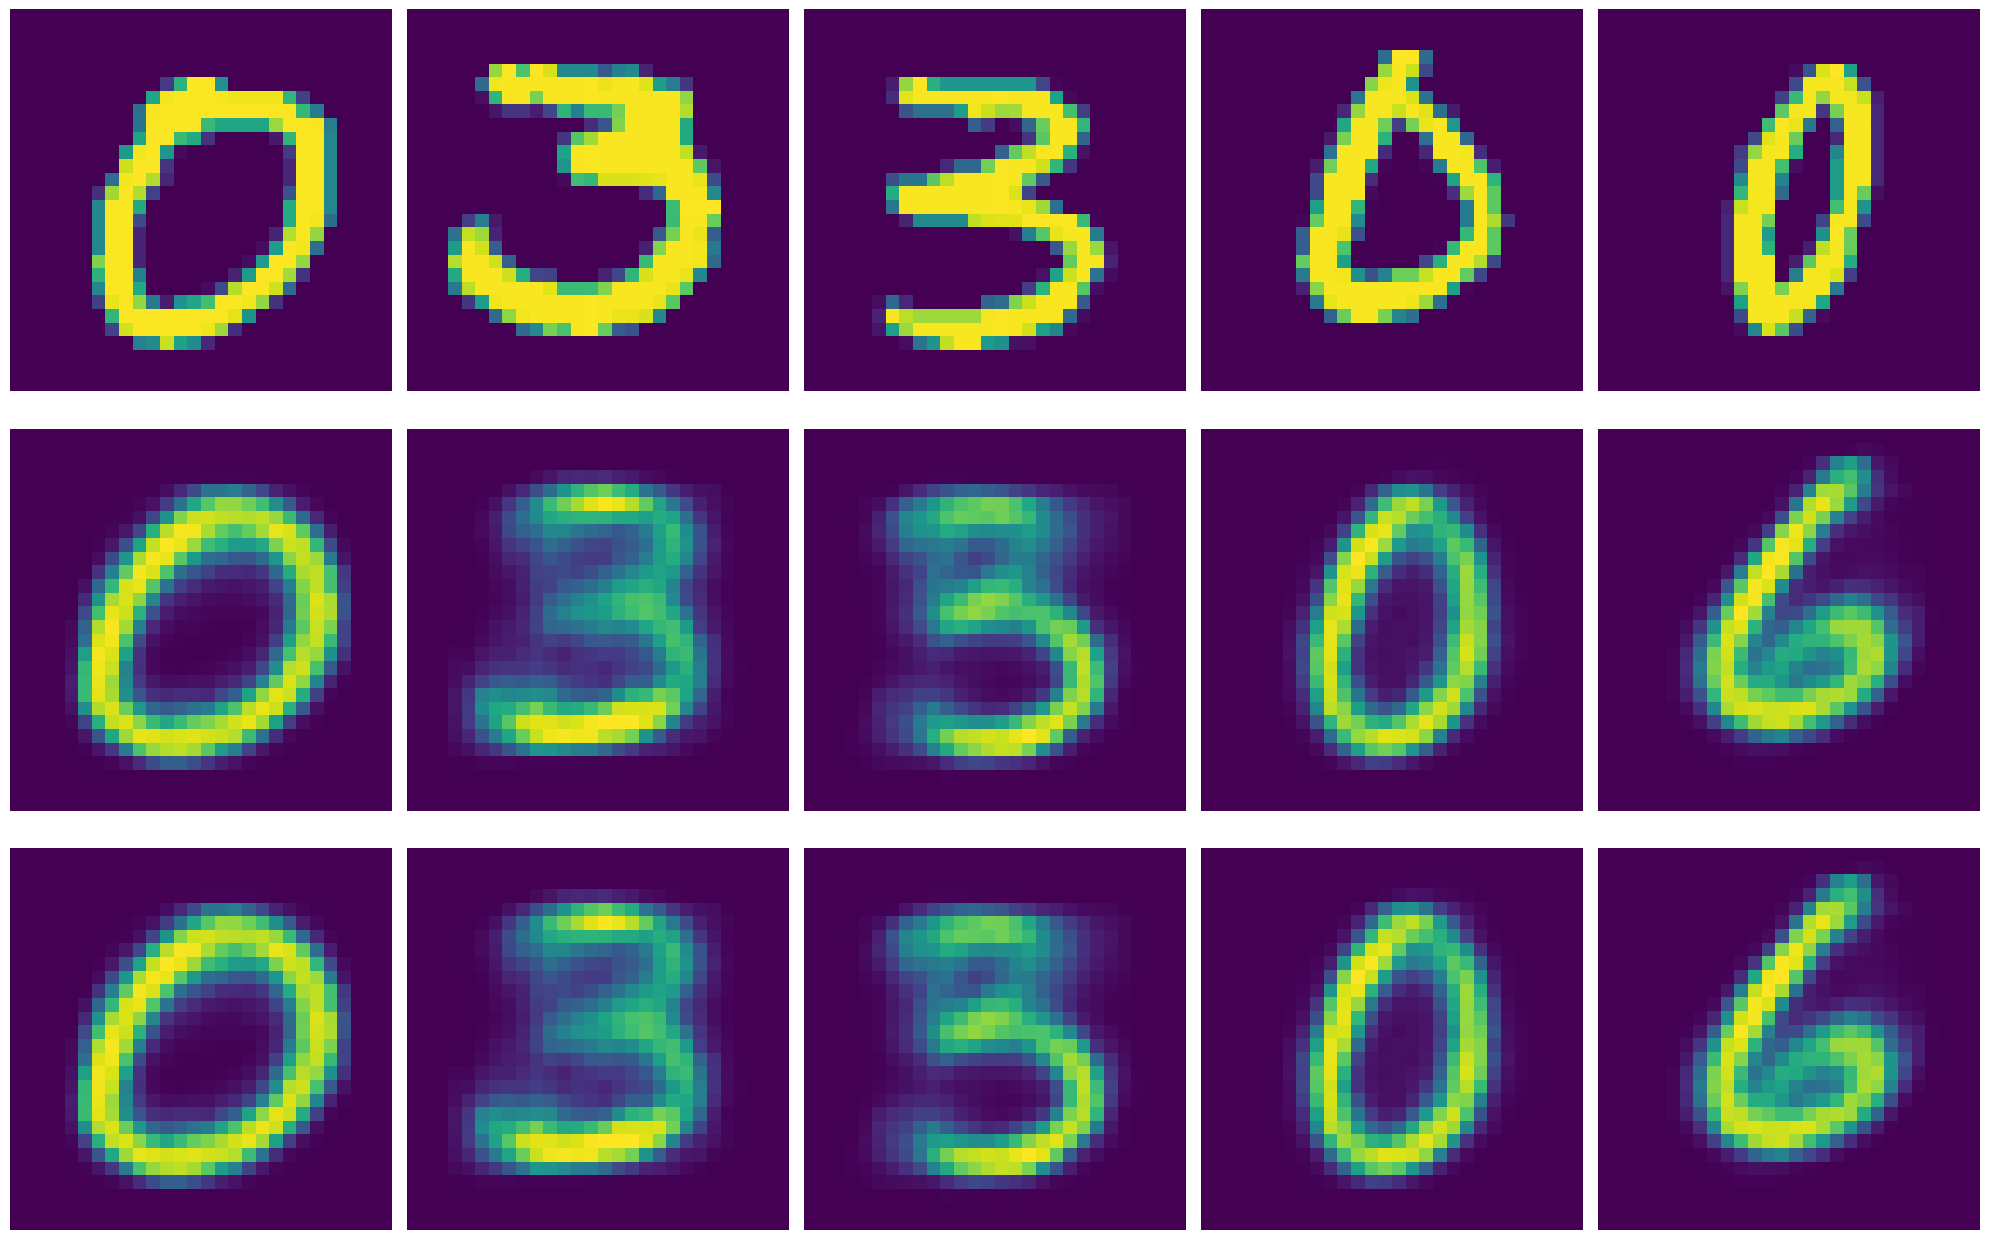

In [6]:
fig, (axs1, axs2, axs3) = plt.subplots(nrows=3, ncols=5, figsize=[20, 13])

manager.model.to('cpu')
manager.model.eval()

for x, y in manager.train_dataloader:
    with torch.no_grad():
        h = manager.model.get_submodule("encoder")(x)
        mu = h[:, :2]
        x_hats = manager.model.get_submodule("decoder")(mu)
    for ax, img in zip(axs1, x[:5]):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    for ax, img in zip(axs2, x_hats):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')

    manager.model.to('cpu')
    manager.model.eval()

    with torch.no_grad():
        manager.swap_current_model('vanilla')
        h = manager.model.get_submodule("encoder")(x)
        mu = h[:, :2]
        x_hats = manager.model.get_submodule("decoder")(mu)
    for ax, img in zip(axs3, x_hats):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    
    break
plt.tight_layout()

# 10 epochs